Using TensorFlow backend.
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In value[[3L]](cond) :
  warnings.warn(x, RRuntimeWarning)
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  "getThreads" not available for .C() for package "RevoUtilsMath"

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 2: 
  warnings.warn

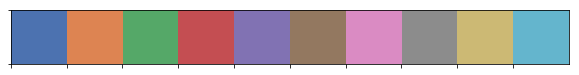

In [1]:
# compute
import numpy as np
import pandas as pd
# import keras

# data io
import glob
# import deepdish as dd
import sys
sys.path.append('../')

# image
# import cv2

# plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette(sns.color_palette('deep'))
sns.palplot(sns.color_palette())

# spykes
# from spykes.neuropop import NeuroPop
# from spykes.neurovis import NeuroVis

# stats
from scipy.stats import circmean

# machine learning
import xgboost as xgb

# local
# import V4pyutils as V4
from V4pyutils import *

from sklearn.manifold import TSNE, MDS, SpectralEmbedding
from tqdm import tqdm
# from hyperopt import fmin, hp, Trials, tpe, STATUS_OK

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


### Load features

In [2]:
h5path = '../V4pydata/H5data/M4/'
data = pd.read_excel('/home/klab/Projects/02-V4py/V4py/V4pydata/natural_artificial.xlsx')
data_M4 = data[data['Animal']=='M4']

art_df = pd.read_pickle('../02-preprocessed_data/M4/merged_art_data_across_sessions')
art_df['predictors.hue'] = art_df['predictors.hue'].apply(np.radians)-np.pi

df_neurons = pd.read_pickle('../02-preprocessed_data/M4/data_to_combine_across_sessions')

nat_df = pd.read_pickle('../02-preprocessed_data/M4/merged_nat_data_across_sessions')

nat_features = pd.read_pickle('../02-preprocessed_data/M4/nat_features_16bin_hist')

# image_categories = np.load('knn_labels_final.npy')

In [3]:
df_neurons_good = pd.read_pickle('../02-preprocessed_data/M4/data_to_combine_across_sessions=predictable')

In [6]:
sat_nat_features = pd.read_pickle('../02-preprocessed_data/M4/nat_features_16bin_hist_sat_weighted')

In [14]:
def prep_data_and_fit_neurons_M4(df_neurons, df_data, model='XGB_poisson', session = 'art', 
                         nat_features = None, image_feature = 'hue.histogram', name  = None,
                         verbose = 0, plot=False, which_neurons = 'all',joint = False,
                         simulated_responses = None, image_categories = None, category = None,
                             lambd = 0, art_XGB = None, resample = False, fit_on_halves = False):
    """
    Fits neural data with specified model
    
    
    Inputs:
    ======
    df_neurons = dataframe with neural data
    df_data = dataframe with all data. Must contain 'session_number' column
    nat_features = precomputed natural features. Result of get_nat.features
                        Required when session = 'nat'.
    
    Options:
    ========
    image_feature = {hue.histogram, hue.mean, vgg.l8, vgg.l7, vgg.l6, vgg.l5}
                        What feature to use for the natural images. 
                        Required when session = 'nat'.
                        
    model = what algorithm to feed to fit_cv 
    session = {'art', 'nat'} Which session type to fit to
    plot = {True, False} Whether to plot the fits
    verbose = {0,1,2} how much to print
    which_neurons = 'all', or list of indices of neurons to fit (in case you want just one, say)
    joint = whether to use non-images features too
    simulated_responses = list of neuron's responses. 
    valid_images = boolean vector of length nat_features.index
    
    Outputs:
    ========
    df_fits: A dataframe with a single column listing, for each neuron, a dictionary with 4 value/key pairs:
    'hue', 'spike_counts', 'predicted_spike_counts', 'pseudo_R2'
    
    """
    assert session in ['art', 'nat']
    assert model in ['XGB_poisson', 'GLM_poisson','linear_regression','fitted_keras',
                     'art_model','art_model_mean_corrected']
    if session is 'nat':
        assert nat_features is not None
        assert image_feature in \
             ['hue.histogram', 'hue.mean', 'vgg.l8', 'vgg.l7', 'vgg.l6', 'vgg.l5']
    if model is 'fitted_keras':
        assert image_feature in ['vgg.l8', 'vgg.l7', 'vgg.l6', 'vgg.l5'] and session is 'nat'
    if model is 'art_model':
        assert image_feature == 'hue.histogram'
        assert art_XGB is not None
            
        # handle situation where we're using the mean-firing-rate corrected art. tuning curves as the model on nat. scenes
    correct_mean = False
    if model == 'art_model_mean_corrected':
        correct_mean = True
        model = 'art_model'
        
    if which_neurons is 'all':
        which_neurons = df_neurons.index
    elif isinstance(which_neurons,int):
        which_neurons = [which_neurons]
        
    if image_categories is not None:
        assert image_categories.shape == (len(nat_features),)
        
    if name is None:
        name = session+'_'+model+'_'+image_feature
    
    df_fits = pd.DataFrame(columns=[name])
    which_session = session + '_sessions'
    
    # Compute feed forward features for plain hue image
    if session == 'nat':
        plain_hue = np.linspace(-np.pi, np.pi, 360)
        if image_feature in ['vgg.l8', 'vgg.l7', 'vgg.l6', 'vgg.l5']:
            
            # build model
            
            if image_feature == 'vgg.l8':
                vgg_model= vgg_transfer_ari(n_pops=0)
                n_nodes = 1011
                if not joint: n_nodes = 1000
            elif image_feature == 'vgg.l7':
                vgg_model= vgg_transfer_ari(n_pops=1)
                n_nodes = 4107
                if not joint: n_nodes = 4096
            elif image_feature == 'vgg.l6':
                vgg_model= vgg_transfer_ari(n_pops=2)
                n_nodes = 4107
                if not joint: n_nodes = 4096
            elif image_feature == 'vgg.l5':
                vgg_model= vgg_transfer_ari(n_pops=3)
                n_nodes = 25099
                if not joint: n_nodes = 25088
            
            Xplain = list()
            stimpath = '../V4pydata'
            for stim_id in range(360):
                imname = '/stimuli/M3/Hues/img%03d.jpg' % stim_id
                filename = stimpath + imname
                I = load_and_preprocess_ari(filename)
                Xplain.append(np.squeeze(vgg_model.predict(I)))
            Xplain = np.array(Xplain)
            n_bins = Xplain.shape[1]
        elif image_feature == 'hue.histogram':
            # Define histograms of plain hue stimuli
            n_bins = 16
            Xplain = onehothue(plain_hue, n_bins=n_bins)
            image_feature += '.full'
        elif image_feature == 'hue.mean':
            Xplain = plain_hue.reshape((360,1))
    
    ######### Get tuning curves for all neurons ###########

    for neuron_id, neuron_name in tqdm(df_neurons['name'].iteritems()):
        
        if neuron_id not in which_neurons:
            continue

        if verbose>0:
            print 'Running neuron ' + neuron_name, neuron_id


        ### Get proper X and Y data ~~~~~~~~~~~~~~~

        # Extract session numbers
        sessions_of_interest = df_neurons.loc[neuron_id][which_session]

        # Grab relevant data
        if session is 'art':
            
            df_sessions_of_interest = df_data.loc[df_data['session.number'].isin(sessions_of_interest)]
            
            covariates =  ['predictors.hue', 
                           'predictors.hue_prev', 
                           'predictors.stim_dur', 
                           'predictors.off_to_onset_times']
            

            # Get covariates
            X = df_sessions_of_interest[covariates].values  
            # for plotting
            x_data = df_sessions_of_interest['predictors.hue'].values
            

            
        else:  # get natural feature
            if image_categories is not None:
                in_category = nat_features['accepted_indices'].loc[image_categories==category]
            else:
                in_category = nat_features['accepted_indices']
            
            df_sessions_of_interest = df_data.loc[df_data['session.number'].isin(sessions_of_interest) & \
                                             df_data.index.isin(in_category)]
            #-----------------
            # Get covariates
            #-----------------
            # Select sessions of interest
            indices_of_interest = np.array(df_sessions_of_interest.index)
            nat_features_of_interest = \
                nat_features.loc[nat_features['accepted_indices'].isin(indices_of_interest)]

            # Convert everything to array

            n_samples = len(nat_features_of_interest)
            
            if n_samples < 100: 
                if verbose>0: print('skipped: ', neuron_id)
                #we'll add the neuron to the datafrom but without any of the features
                #df_fits.loc[neuron_id] = 'neuron_skipped'
                continue

            # Image features
            try: n_features = len(nat_features_of_interest['image_features']\
                             [nat_features_of_interest.index[0]][image_feature])
            except TypeError: # bad practice: assuming all errors will be for same reason. 

                n_features = 1

                    
            image_features_array = np.zeros((n_samples, n_features))
            image_features_list = [nat_features_of_interest['image_features'][k][image_feature] \
                                   for k in nat_features_of_interest.index]
            for k in range(n_samples):
                image_features_array[k, :] = image_features_list[k]

            # Non-image features
#             if joint == True:
            n_features = np.shape(nat_features_of_interest['non_image_features']\
                                  [nat_features_of_interest.index[0]].values)[0]
            non_image_features_array = np.zeros((n_samples, n_features))
            non_image_features_list = [nat_features_of_interest['non_image_features'][k].values \
                                   for k in nat_features_of_interest.index]
            for k in range(n_samples):
                non_image_features_array[k, :] = non_image_features_list[k]
                
            # for plotting
                            # remember we're plotting as a function of HUE MEAN
            x_data = np.array([nat_features_of_interest['image_features'][k]['hue.mean.full'] \
                      for k in nat_features_of_interest.index])

            # Concatenate
            if joint:
                X = np.concatenate((image_features_array, 
                                   non_image_features_array), 
                                  axis=1)
            else:
                X = image_features_array


        labels = df_sessions_of_interest['im.name']  if session is 'nat' else []
        n_cv = 8

        # Get spike counts
        Y = df_sessions_of_interest[neuron_name].values
        
        # Rescale by the stimulus duration for linear regression
        if session == 'nat':
            col = np.argwhere(nat_features['non_image_features']\
                                  [0].keys() == 'predictors.stim_dur')[0,0]
            Y = Y/non_image_features_array[:,col]
            
        
        if simulated_responses is not None:
            sim_spikes = simulated_responses[neuron_id]
            assert sim_spikes.shape == Y.shape
            Y = sim_spikes
   
        
        if resample is True:
            X, Y, labels = bootstrap3(X,Y,labels)
                    
        if fit_on_halves:
            """Split the data in half, deterministically, making sure that trials from the same image are in the same fold."""
            half1, half2 = list(LabelKFold(labels, n_folds=2))[0]
            
            X1, Y1, labels1 = X[half1],Y[half1],labels[half1]
            X2, Y2, labels2 = X[half2],Y[half2],labels[half2]    
            

      
        #### Fit models ~~~~~~~~~~~~~~~~~
        
        
        
        my_model = None
        
        if model == 'art_model':
            # predictions from a fit tuning curve to artificial images
            from scipy.stats import binned_statistic
            def art_model(Xr,Yr,Xt,neuron_id=neuron_id,nbins=n_bins):
                assert nbins == Xr.shape[1]
                #get average spike rate in each bin
                hue = art_XGB.iloc[:,0][neuron_id]['hue']
                spikes =   art_XGB.iloc[:,0][neuron_id]['spike_counts']/\
                           art_XGB.iloc[:,0][neuron_id]['duration']
                        
                        
                bin_means, bin_edges, binnumber = binned_statistic(hue,spikes,statistic='mean',bins=nbins)

                # normalize histogram by number of pixels
                Xt_unit = Xt / np.linalg.norm(Xt)

                # return lin. comb.
                prediction =  np.dot(Xt_unit, np.reshape(bin_means,(nbins,1)))
                if correct_mean:
                    art_mean = np.mean(art_XGB.iloc[:,0][neuron_id]['spike_counts']/\
                       art_XGB.iloc[:,0][neuron_id]['duration'])
                    nat_mean = np.mean(Y)
                    
                    prediction += nat_mean - art_mean
                return prediction
            my_model = art_model
            
            
        if model == 'GLM_poisson':
            r = ro.r
            r.library('glmnet')
      
            def r_glmnet(Xr,Yr,Xt):
                yr = ro.FloatVector(Yr) # use factors
                try:
                    trained_model = r['cv.glmnet'](Xr, yr, family="poisson",alpha=0.1,standardize=False)

                    if lambd == 'min':
                        lambda_min = np.asanyarray(trained_model.rx2('lambda.min'))[0]*.10
                    else: 
                        lambda_min = np.asanyarray(trained_model.rx2('lambda.1se'))[0]
    #                print(lambda_min)
                    Yt = r['predict'](trained_model,s=lambda_min,newx=Xt,type="response")
                except:
                    Yt = np.zeros(Xt.shape[0])
                return np.array(list(Yt))
            my_model = r_glmnet
            model = 'myGLM'
                
        if model is not 'fitted_keras':   
            # can't used fitted keras to predict for images because it was fit on those!! will be overfit
            Yt_hat, pseudo_R2 = fit_cv(X, Y,
                                      stratify_by_labels=labels,
                                      n_cv=n_cv, epochs=50,batch_size=128,
                                      algorithm= model,model = my_model,
                                      verbose=verbose, lambd = lambd)
          
            
        if model == 'myGLM':
            model = 'GLM_poisson'
        
        ### Get tuning curves
        if session is 'nat' and model is not 'art_model':
            # Fit the  model
            if model == 'fitted_keras':
                model_instance = keras_GLM(n_nodes, 100)
                if joint:
                    model_instance.load_weights('../02-preprocessed_data/M3/fit_models/'\
                                           +str(neuron_id)+'_'+neuron_name+'_l6_joint')
                else:
                    model_instance.load_weights('../02-preprocessed_data/M3/fit_models/'\
                                           +str(neuron_id)+'_'+neuron_name+'_l6_image')
            elif model is not 'GLM_poisson':
                if fit_on_halves:
                    model_instance1 = fit(X1, Y1, algorithm=model,epochs=50,batch_size=128, lambd = lambd)
                    model_instance2 = fit(X2, Y2, algorithm=model,epochs=50,batch_size=128, lambd = lambd)
                else:
                    model_instance = fit(X, Y, algorithm=model,epochs=50,batch_size=128, lambd = lambd)
            
            ### Predict on plain hue stimuli ###
            if joint:
                 # use or no?
                random_resample = np.random.randint(0, n_samples, Xplain.shape[0])
                # set :Xplain.shape[0] below to random_resample if yes
                Xplain_augment = np.concatenate((Xplain, 
                                      non_image_features_array[:Xplain.shape[0], :]), axis=1)
            else:
                Xplain_augment = Xplain
            
            if fit_on_halves:
                if model == 'XGB_poisson':
                    Yplain_hat1 = model_instance1.predict(xgb.DMatrix(Xplain_augment))
                    Yplain_hat2 = model_instance2.predict(xgb.DMatrix(Xplain_augment))
                elif model is 'GLM_poisson':
                    Yplain_hat1 = r_glmnet(X1, Y1, Xplain_augment)
                    Yplain_hat2 = r_glmnet(X2, Y2, Xplain_augment)
                else:
                    Yplain_hat1 = model_instance1.predict(Xplain_augment)
                    Yplain_hat2 = model_instance2.predict(Xplain_augment)
                
            else:
                if model == 'XGB_poisson':
                    Yplain_hat = model_instance.predict(xgb.DMatrix(Xplain_augment))
                elif model is 'GLM_poisson':
                    Yplain_hat = r_glmnet(X, Y, Xplain_augment)
                else:
                    Yplain_hat = model_instance.predict(Xplain_augment)

        
        # plot responses. for natural images, it's response to images vs. average hue of image
        if plot:
            y_data = Y
            xlabel = 'hue'
            plot_xy(x_data=x_data, y_data=y_data,
                       y_model=Yt_hat,
                       lowess_frac=0.5, xlabel=xlabel, model_name=model, 
                       x_jitter_level=0., y_jitter_level=0.5, title = 'max')
            #plt.title((X[np.argmax(Yt_hat)]*180/np.pi)[0])
            #plt.ylim([0,4])
            plt.show()
            
            
        temp = dict()
        temp['hue'] = x_data
        temp['spike_counts'] = Y
        
        
        if session == 'art':
            temp['duration'] = df_sessions_of_interest['predictors.stim_dur'].values
            temp['time_normalized_counts'] = Y/df_sessions_of_interest['predictors.stim_dur'].values
        else:
#             if joint:
            col = np.argwhere(nat_features['non_image_features']\
                                  [0].keys() == 'predictors.stim_dur')[0,0]
            Y = Y/non_image_features_array[:,col]
            temp['time_normalized_counts'] = Y
            
        
        if model is not 'fitted_keras':
            temp['predicted_spike_counts'] = np.squeeze(Yt_hat)
            temp['pseudo_R2'] = pseudo_R2
                     
        if session is 'nat' and model is not 'art_model':
            temp['plain_hue'] = plain_hue
            
            if fit_on_halves:
                temp['plain_predicted_spike_counts_half1'] = np.squeeze(Yplain_hat1)
                temp['plain_predicted_spike_counts_half2'] = np.squeeze(Yplain_hat2)
            else:
                temp['plain_predicted_spike_counts'] = np.squeeze(Yplain_hat)
        
        df_fits.loc[neuron_id] = [temp]
        
    return df_fits

### Get all the tuning curves for all methods
#### We fit each method N times, each time sampling the original data with replacement

In [8]:
which_neurons = np.array([  2,  3, 12, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       29, 30, 31, 33, 34, 36, 37, 38, 40, 41, 42, 43, 48, 49, 50, 51, 53,
       55, 56, 58, 61, 62, 67, 68, 69, 70, 71, 77, 79])

In [9]:
art_XGB = prep_data_and_fit_neurons_M4(df_neurons, art_df, session = 'art', model='XGB_poisson',
                          verbose = 0, plot=False, which_neurons = 'all',joint=True)


80it [03:30,  2.57s/it]


In [10]:
def fit_all_methods_resample(which_neurons):
    
    nat_hist_glm_lowreg = prep_data_and_fit_neurons_M4(df_neurons, nat_df, model='GLM_poisson', session = 'nat', 
              nat_features = sat_nat_features, image_feature = 'hue.histogram', name = 'glm_lowreg', lambd='min',
              verbose = 0, plot=False, which_neurons = which_neurons,joint=True, resample = True,)
    
#     nat_hist_lin = prep_data_and_fit_neurons_M4(df_neurons, nat_df, model='linear_regression', session = 'nat', 
#                   nat_features = sat_nat_features, image_feature = 'hue.histogram', name = 'lin_all',
#                   verbose = 0, plot=False, which_neurons = which_neurons,joint=True,lambd=0.01, resample = True,)
    
    nat_hist_XGB = prep_data_and_fit_neurons_M4(df_neurons, nat_df, model='XGB_poisson', session = 'nat', 
                  nat_features = sat_nat_features, image_feature = 'hue.histogram', name = 'xgb',
                  verbose = 0, plot=False, which_neurons = which_neurons,joint=True, resample = True)
    
    all_methods = nat_hist_glm_lowreg.join(nat_hist_XGB)
    
    return all_methods

In [11]:
def fit_glm(which_neurons):
    nat_hist_glm_lowreg = prep_data_and_fit_neurons_M4(df_neurons, nat_df, model='GLM_poisson', session = 'nat', 
              nat_features = sat_nat_features, image_feature = 'hue.histogram', name = 'glm_lowreg', lambd='min',
              verbose = 0, plot=False, which_neurons = which_neurons,joint=False, resample = True,)
    return nat_hist_glm_lowreg

In [ ]:
bootstrapped_glm = [fit_glm(which_neurons)]

0it [00:00, ?it/s]/opt/anaconda/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: foreach

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loaded glmnet 2.0-16


  warnings.warn(x, RRuntimeWarning)
80it [08:41,  7.40s/it]


In [ ]:

# then resample
n=100


for i in range(n):
    print(i)
    a = fit_glm(which_neurons)
    bootstrapped_glm.append(a)


0it [00:00, ?it/s]

0


80it [08:38,  7.34s/it]
0it [00:00, ?it/s]

1


80it [08:38,  7.48s/it]
0it [00:00, ?it/s]

2


80it [08:44,  7.45s/it]
0it [00:00, ?it/s]

3


80it [08:41,  7.60s/it]
0it [00:00, ?it/s]

4


80it [08:40,  7.42s/it]
0it [00:00, ?it/s]

8


80it [08:40,  7.66s/it]
0it [00:00, ?it/s]

9


80it [08:38,  7.54s/it]
0it [00:00, ?it/s]

10


80it [08:44,  7.41s/it]
0it [00:00, ?it/s]

11


39it [04:33, 10.58s/it]

In [27]:
import pickle
pickle.dump(bootstrapped,open("all_fit_TCs_resampled_M4.p",'wb'))

## Many neurons have tiny spike rates

In [30]:
# this is to confirm; which neurons contains only neurons with rates above 1Hz
mean_rates = [np.mean(art_XGB.iloc[:,0][neuron_id]['spike_counts']/\
                       art_XGB.iloc[:,0][neuron_id]['duration'])
                 for neuron_id in which_neurons]
mean_rates = np.array(mean_rates)

In [31]:
neurons_above_1Hz = np.where(mean_rates > 1.)[0]

#### Plot some tuning curves

In [119]:
import pickle
bootstrapped = pickle.load(open("all_fit_TCs_resampled_M4.p",'rb'))

In [120]:
def CI_along_axis0(yy):
    """This returns the 5 and 95% CI for a matrix, over the first index. Not the mean - the CI on the value"""
    # each row is a new run; each column a neuron. So we want to sort over runs
   
    means = np.sort(yy, axis=0)
    # then re
    crit05 = means[len(yy)//20]
    crit95 = means[19*len(yy)//20]
    return crit05,crit95

In [121]:
def get_tuning_curves_with_CI(bootstrapped_fits, which_neurons = 'all', verbose = 0):
    """From a list of dataframes, each one being the outout of `fit_all_methods_resample`, we 
    build the tuning curve from each of them and then return the mean curve along with the 95% CI"""
    hue = bootstrapped_fits[0].iloc[0].iloc[0]['plain_hue']
    
    all_curves = dict()
    
    if which_neurons == 'all':
        which_neurons = range(80)
        
    try: len(which_neurons)
    except TypeError:
        which_neurons = [which_neurons]
    
    for method in bootstrapped_fits[0].columns:
        all_curves[method]=list()
        if verbose>0:print(method)
        
        for neuron_id in which_neurons:
            all_responses = list()
            for single_fit in bootstrapped_fits:
                predicted_response = single_fit.loc[neuron_id,method]['plain_predicted_spike_counts']
                all_responses.append(predicted_response)
            all_responses = np.vstack(all_responses)
            mean_curve = np.mean(all_responses,axis=0)

            low, high = CI_along_axis0(all_responses)
            
            results_dict = {'mean':mean_curve,
                           'low':low,
                           'high':high}
            all_curves[method].append(results_dict)
                
    return all_curves

In [122]:
def lowess_smooth(hue,response,lowess_frac = .2, tied_ends = True, num_boots = None):
    """Take a tuning curve and smooth it."""
    if tied_ends == False:
        lowess = sm.nonparametric.lowess
        smoothed_data = lowess(np.squeeze(response), hue, frac=lowess_frac)
        
    else:
        # concatenate data with itself to approximate a circular hue wheel.
        # We'll take just the middle section
        y_data = np.hstack((response, response))
        x_data = np.hstack((hue, hue+2*np.pi))
        l = x_data.shape[0]


        # User lowess smoothing to smooth data and model
        lowess = sm.nonparametric.lowess
        smoothed_data = lowess(np.squeeze(y_data), x_data, frac=lowess_frac)
        
        bounds = None
        if num_boots is not None:
            straps = np.zeros((num_boots, x_data.shape[0]))
            for i in range(num_boots):
                subset_x, subset_y = bootstrap2(x_data, np.squeeze(y_data))
                this_smoothed = lowess(subset_y, subset_x, frac=lowess_frac, )
                straps[i,:] = this_smoothed[:,1]

            perc5 = np.percentile(straps,5,axis=0,)
            perc95 = np.percentile(straps,95,axis=0,)
            
            perc5 = perc5[l//4:(3*l)//4]
            perc95 = perc95[l//4:(3*l)//4]
            l2 = len(perc5)//2
            perc5 = np.roll(perc5, l2)
            perc95 = np.roll(perc95, l2)
            bounds = perc5,perc95

        # Downsample now just to middle
        smoothed_data = smoothed_data[l//4:(3*l)//4,:]
        x_data = x_data[l//4:(3*l)//4]
        y_data = y_data[l//4:(3*l)//4]

        # and get x axis back to around 0
        smoothed_data[:,0] += -np.pi
        x_data[0] += -np.pi

        # and roll the y data back to original range
        l = len(smoothed_data[:,0])//2
        smoothed_data[:,1] = np.roll(smoothed_data[:,1], l)
        y_data = np.roll(y_data,l)
    
    return smoothed_data[:,0],smoothed_data[:,1], bounds

In [123]:
def return_binned_art_TC(art_XGB, neuron_id,n=16):
    bin_means, bin_edges, binnumber = stats.binned_statistic(art_XGB.iloc[:,0][neuron_id]['hue'],
                          art_XGB.iloc[:,0][neuron_id]['spike_counts']/\
                           art_XGB.iloc[:,0][neuron_id]['duration'], statistic='mean',
                          bins = n)
    
    bin_std, bin_edges, binnumber = stats.binned_statistic(art_XGB.iloc[:,0][neuron_id]['hue'],
                      art_XGB.iloc[:,0][neuron_id]['spike_counts']/\
                       art_XGB.iloc[:,0][neuron_id]['duration'], statistic='std',
                      bins = n)
    
    bin_count, bin_edges, binnumber = stats.binned_statistic(art_XGB.iloc[:,0][neuron_id]['hue'],
                          art_XGB.iloc[:,0][neuron_id]['spike_counts']/\
                           art_XGB.iloc[:,0][neuron_id]['duration'], statistic='count',
                          bins = n)
    
    hues = bin_edges[1:] - (bin_edges[1] - bin_edges[0])/2
    means = bin_means
    lows = bin_means-bin_std/np.sqrt(bin_count)
    highs  = bin_means+bin_std/np.sqrt(bin_count)
    return hues, means, lows, highs


In [124]:
def plot_tuning_curves(bootstrapped_fits, neuron, art_XGB, which_methods = 'all',smoothing = True,
                      n_bins = 16, savename = None, smoothing_frac = 1/16., legend = None,
                       also_scatter = False):
    all_curves = get_tuning_curves_with_CI(bootstrapped_fits, neuron)
    cc = [sns.color_palette(n_colors = 50)[0]] +sns.color_palette(n_colors = 50)[2:]

    if which_methods=='all':
        which_methods = all_curves.keys()
        
    for i,method in enumerate(which_methods):
        
        if method == 'art':
            
            if smoothing==True:
                hue,tuning_curve,(y_low,y_high) = lowess_smooth(art_XGB.iloc[:,0][neuron]['hue'], 
                    art_XGB.iloc[:,0][neuron]['spike_counts']/art_XGB.iloc[:,0][neuron]['duration'],
                                                                num_boots = 100)
                n_every = len(y_low)//40

                
                plt.plot(hue[::n_every],tuning_curve[::n_every], lw=2, c = cc[i], label = method)
                plt.fill_between(hue[::n_every],y_low[::n_every],y_high[::n_every], alpha = 0.2 , color = cc[i])
            else:
                hues, means, lows, highs= return_binned_art_TC(art_XGB, neuron_id=neuron)
                plt.plot(hues,means, '-o', lw=2, c = cc[i], label = method)
                plt.fill_between(hues,lows,highs, alpha = 0.2 , color = cc[i])
            continue
        
        tuning_curve = all_curves[method][0]['mean']

  
        hue = np.linspace(-np.pi,np.pi,len(tuning_curve))

        okay_predictions = (tuning_curve<80) &(tuning_curve>0)
        tuning_curve = tuning_curve[okay_predictions]
        y_low = all_curves[method][0]['low'][okay_predictions]
        y_high = all_curves[method][0]['high'][okay_predictions]
        hue = hue[okay_predictions]

        if smoothing:
            frac = smoothing_frac
            if also_scatter:
                plt.scatter(hue,tuning_curve, color = cc[i], alpha = 0.5)
                
            hue,tuning_curve,_ = lowess_smooth(hue,tuning_curve, lowess_frac=frac)
            hue,y_low,_ = lowess_smooth(hue,y_low, lowess_frac=frac)
            hue,y_high,_ = lowess_smooth(hue,y_high,lowess_frac=frac)

            plt.plot(hue,tuning_curve, lw=2, c = cc[i], label = method)
            plt.fill_between(hue,y_low,y_high, alpha = 0.2 , color = cc[i])
            
        else:
            #we're binning
            if also_scatter:
                plt.scatter(hue,tuning_curve, color = cc[i], alpha = 0.5)
                
            tuning_curve, bin_edges, binnumber = stats.binned_statistic(hue,tuning_curve, statistic='mean',
                                                                              bins = n_bins)
            y_low, bin_edges, binnumber = stats.binned_statistic(hue,y_low, statistic='mean',
                                                                              bins = n_bins)
            y_high, bin_edges, binnumber = stats.binned_statistic(hue,y_high, statistic='mean',
                                                                              bins = n_bins)

            hue = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])
            plt.plot(hue,tuning_curve, '-o', lw=2, c = cc[i], label = method)
            plt.fill_between(hue,y_low,y_high, alpha = 0.2 , color = cc[i])
    
    
    ax  = plt.gca()
#     plt.axis([-np.pi,np.pi,0,30])
    if smoothing==True:
        colorline(np.linspace(-np.pi,np.pi,len(hue)),
              np.zeros(len(hue)), linewidth=6)

    ax.set_xticks([-np.pi,0,np.pi], minor=False)
#     ax.set_yticks([0,5,10,15], minor=False)
    ax.set_xticklabels(['$-\pi$','0','$\pi$'])
    plt.ylabel('Spikes/s', fontsize = 18)
    plt.xlabel('Hue', fontsize = 18)
    if legend is not None:
        plt.legend(legend,fontsize='medium')
    plt.tight_layout()
    if savename is not None:
        plt.savefig(savename,format='pdf')
    plt.show()

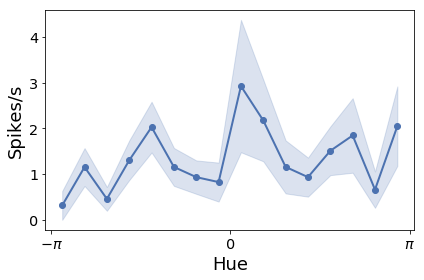

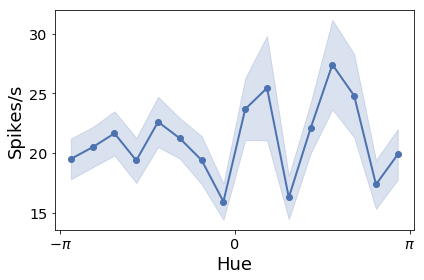

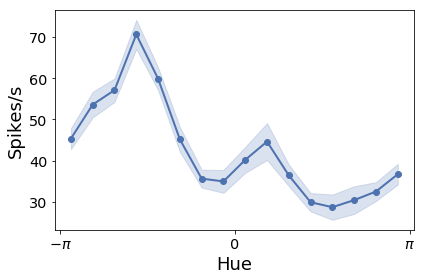

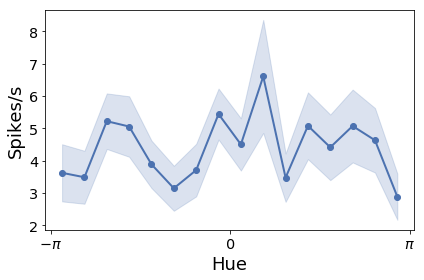

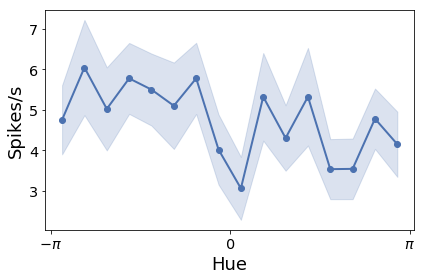

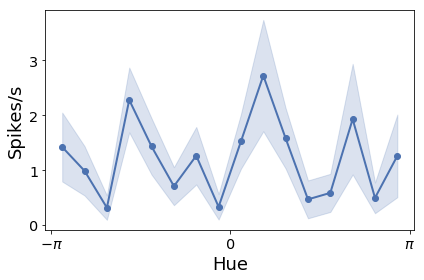

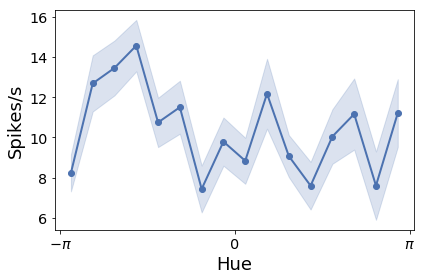

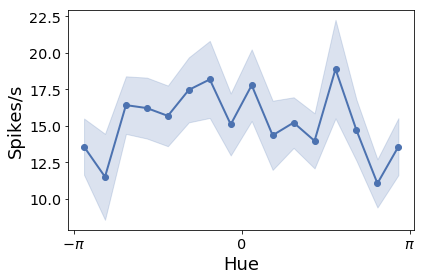

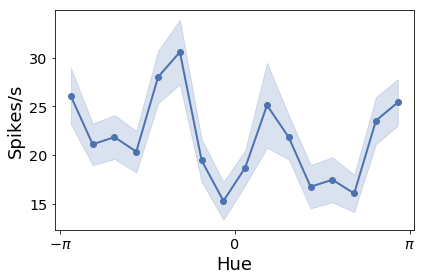

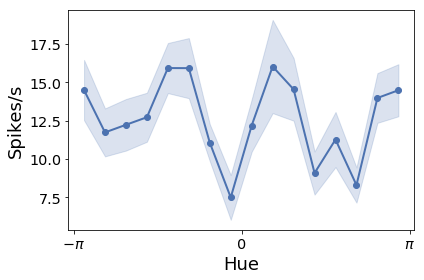

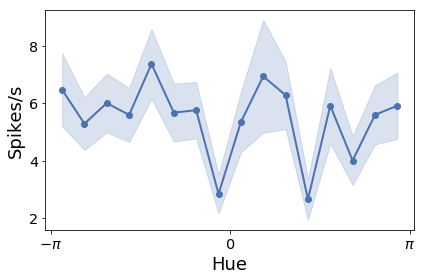

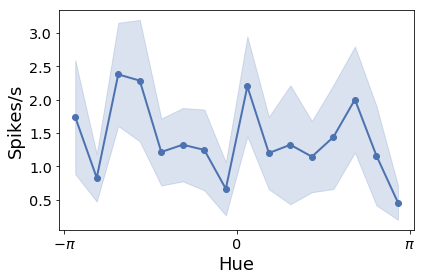

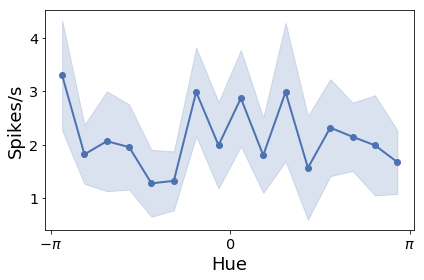

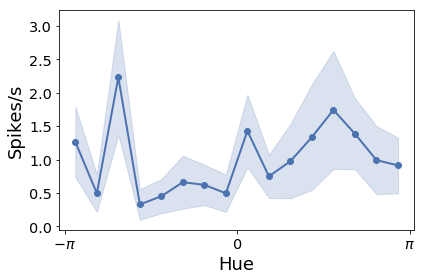

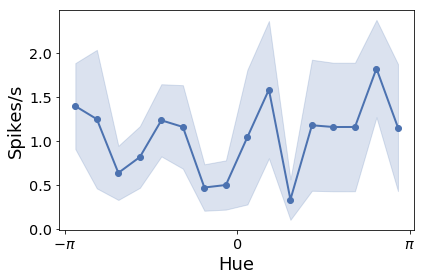

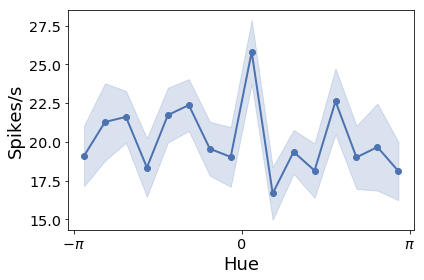

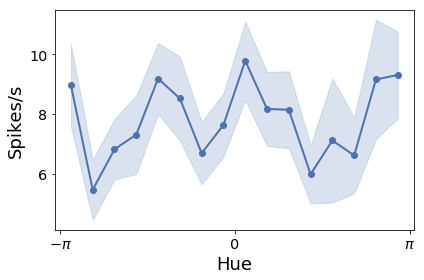

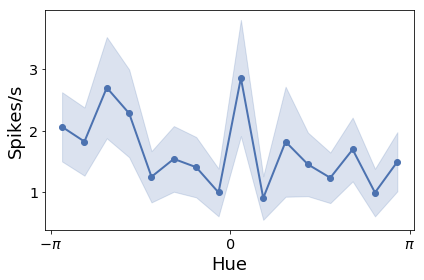

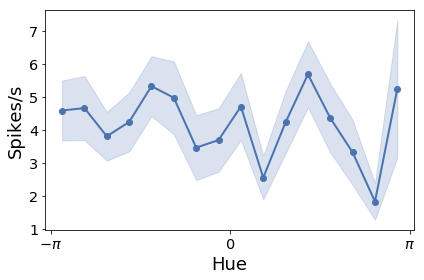

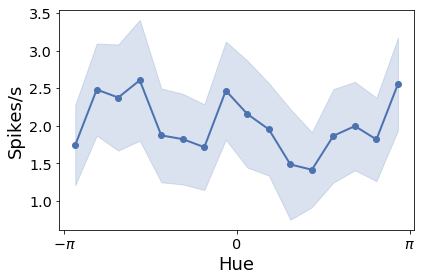

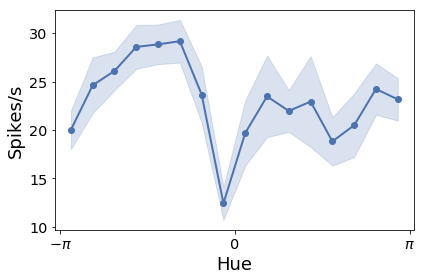

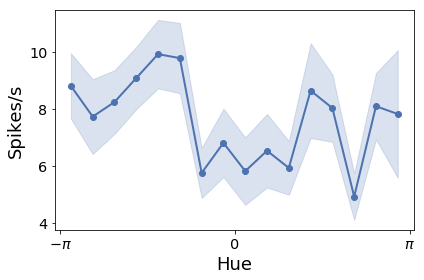

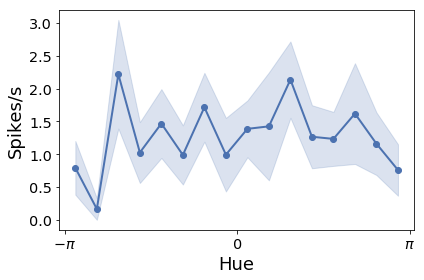

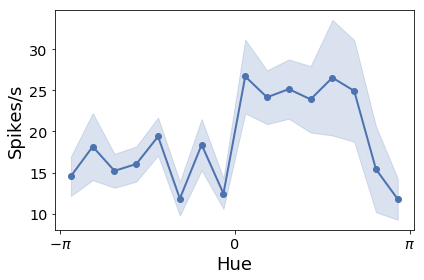

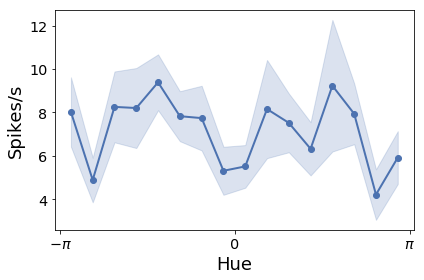

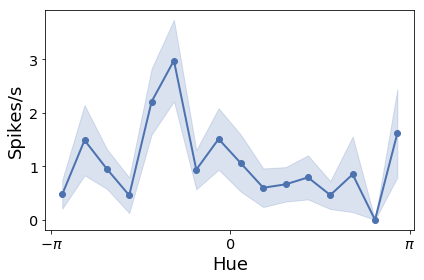

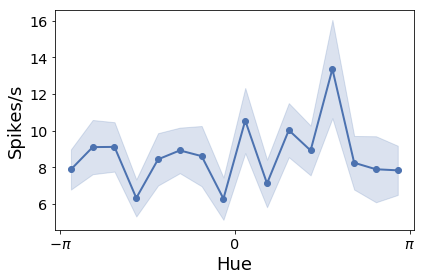

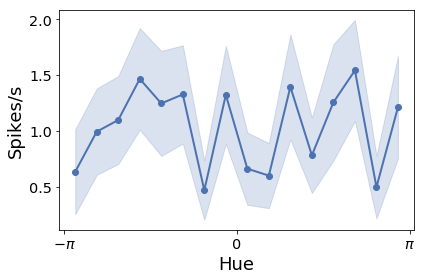

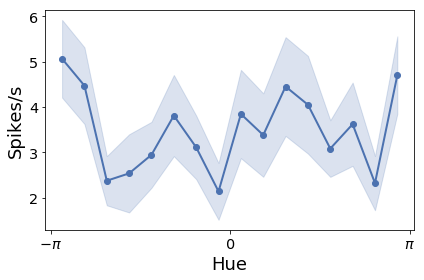

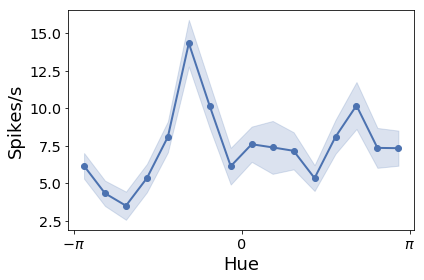

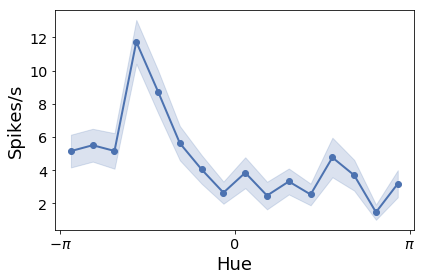

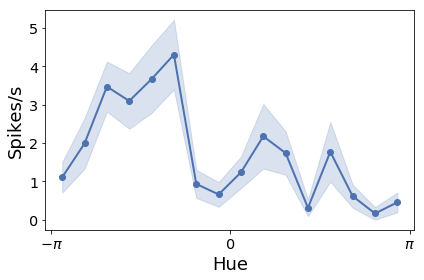

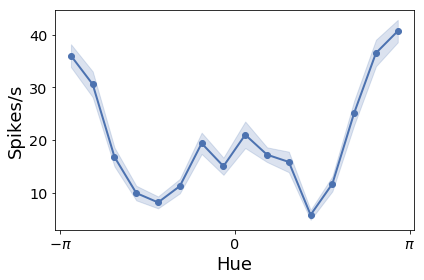

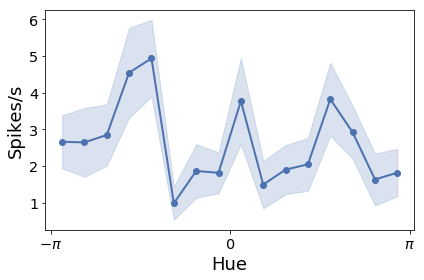

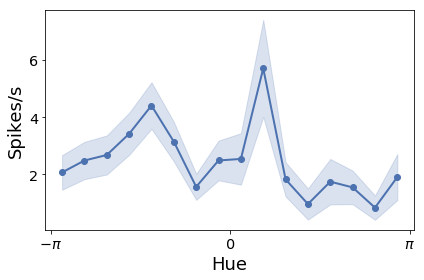

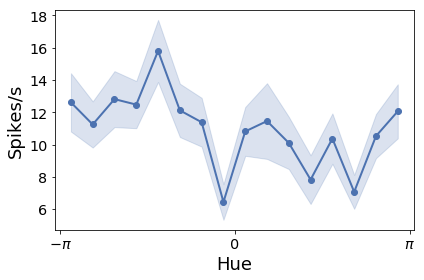

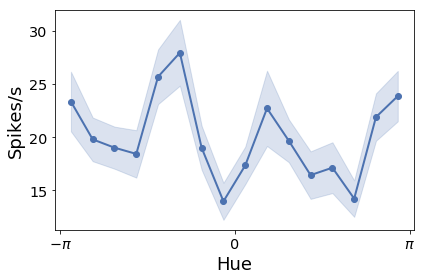

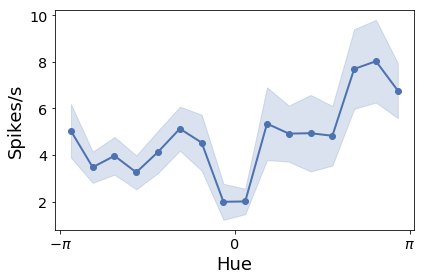

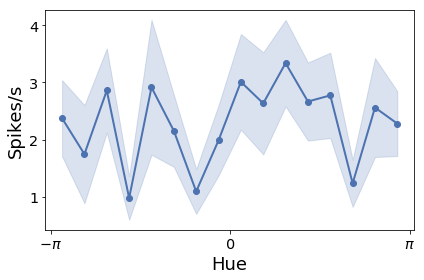

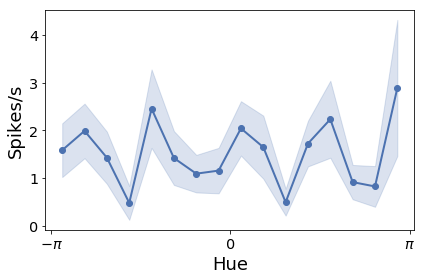

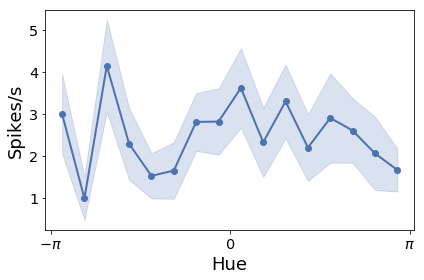

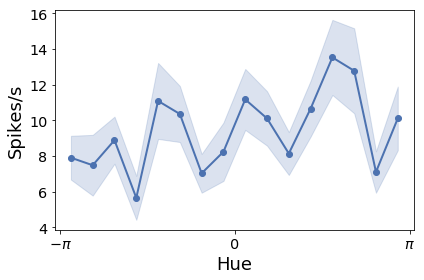

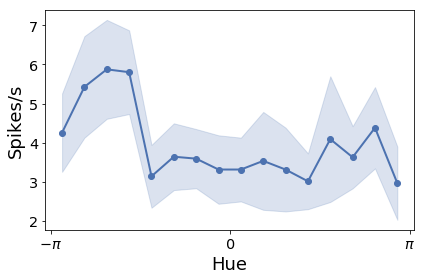

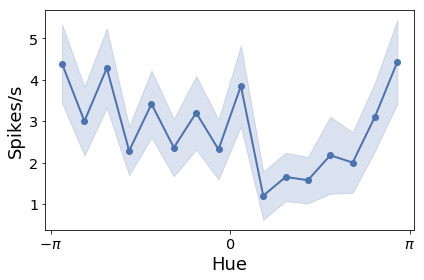

In [41]:
for neuron_id in which_neurons:
    plot_tuning_curves(bootstrapped, neuron=neuron_id, art_XGB=art_XGB, 
                       which_methods=['art'], 
#                        legend = ['Wide-field hue',
#                                  'Nat. Images (GLM)',
#                                  'Nat. Images (Nonlinear)',
#                                 ],
                       smoothing=False, smoothing_frac = .1,
                       also_scatter = True,
    #                    savename = "final_figures/tuning_curves_neuron_{}.pdf".format(neuron_id)
                      )

### Look at the predictions from the WFH tuning curves

In [311]:
# on all images
nat_hist_art_model = prep_data_and_fit_neurons_M4(df_neurons, nat_df, model='art_model_mean_corrected', session = 'nat', 
                          nat_features = sat_nat_features, image_feature = 'hue.histogram', name = 'lin_all',
                          verbose = 0, plot=False, which_neurons = 'all',joint=False,art_XGB=art_XGB)




0it [00:00, ?it/s]


1it [00:00,  1.77it/s]


2it [00:01,  1.76it/s]


3it [00:01,  1.80it/s]


4it [00:02,  1.86it/s]


5it [00:02,  1.91it/s]


6it [00:03,  1.95it/s]


7it [00:03,  1.97it/s]


8it [00:04,  1.99it/s]


9it [00:04,  2.01it/s]


10it [00:05,  2.03it/s]


11it [00:05,  2.04it/s]


12it [00:06,  2.04it/s]


13it [00:06,  2.02it/s]


14it [00:07,  2.00it/s]


15it [00:07,  1.97it/s]


16it [00:08,  1.96it/s]


17it [00:08,  2.00it/s]


18it [00:09,  2.04it/s]


19it [00:09,  2.08it/s]


20it [00:09,  2.10it/s]


21it [00:10,  2.12it/s]


22it [00:10,  2.12it/s]


23it [00:11,  2.12it/s]


24it [00:12,  1.94it/s]


25it [00:12,  1.86it/s]


26it [00:13,  1.84it/s]


27it [00:13,  1.78it/s]


28it [00:14,  1.76it/s]


29it [00:14,  1.73it/s]


30it [00:15,  1.71it/s]


31it [00:16,  1.69it/s]


32it [00:16,  1.71it/s]


33it [00:17,  1.69it/s]


34it [00:17,  1.68it/s]


35it [00:18,  1.69it/s]


36it [00:19,  1.68it/s]


37it [00:19,  1.67it/s]


38it [00:20,  1.69it/s]

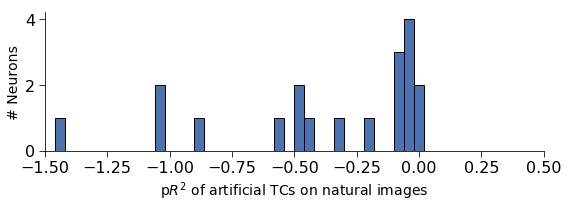

In [312]:


art_model_pR2s_mean_corrected = [np.mean(nat_hist_art_model.iloc[i,0]['pseudo_R2']) for i in which_wfh]

plt.figure(figsize=(8,3))
range_ = (-1.5,.5)
plt.hist(art_model_pR2s_mean_corrected,bins=50, range = range_,edgecolor = 'k')
plt.xlim(range_)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.xlabel('p$R^2$ of artificial TCs on natural images', fontsize=14)
plt.ylabel('# Neurons', fontsize=14)
ax = plt.gca()
simpleaxis(ax)

plt.tight_layout()
plt.savefig('final_figures/artificial_TC_on_nat_images_pr2_wfh.pdf')

plt.show()

## Correlate the TCs on halves of the data for GLM and XGB

In [150]:
def get_CI_for_WFH_halves_correlations(art_XGB, which_neurons = range(80), num_recorrs = 100,nbins=16):
    mean_corrs = []
    lows = []
    highs = []
    for neuron_id in range(80):
        if not (neuron_id in which_neurons):
            continue
        corr_list = []
        for i in range(num_recorrs):
            # these are the two curves
            (hues1, bin_means1), (hues2, bin_means2) = get_TCs_on_two_halves(art_XGB, neuron_id,n=nbins)
            # now correlate
            this_corr_coef = np.corrcoef(bin_means1, bin_means2)[0,1]
            corr_list.append(this_corr_coef)

        # now get the CI
        low,high = CI_along_axis0(corr_list)
        mean_corrs.append(np.mean(corr_list))
        lows.append(low)
        highs.append(high)
    
    return np.array(mean_corrs), np.array(lows), np.array(highs)

## first for the WFH
def get_TCs_on_two_halves(art_XGB, neuron_id,n=16):
    """Splits the trials in half, randomly, and returns the binned tuning curves for each half."""
    
    n_trials = len(art_XGB.iloc[:,0][neuron_id]['hue'])
    mask = np.random.choice([True,False],size=n_trials)
    
    
    # the first curve
    bin_means1, bin_edges1, binnumber1 = stats.binned_statistic(art_XGB.iloc[:,0][neuron_id]['hue'][mask],
                          art_XGB.iloc[:,0][neuron_id]['spike_counts'][mask]/\
                           art_XGB.iloc[:,0][neuron_id]['duration'][mask], statistic='mean',
                          bins = n)
  
    hues1 = bin_edges1[1:] - (bin_edges1[1] - bin_edges1[0])/2
    
    # the second curve
    bin_means2, bin_edges2, binnumber2 = stats.binned_statistic(art_XGB.iloc[:,0][neuron_id]['hue'][~mask],
                          art_XGB.iloc[:,0][neuron_id]['spike_counts'][~mask]/\
                           art_XGB.iloc[:,0][neuron_id]['duration'][~mask], statistic='mean',
                          bins = n)
  
    hues2 = bin_edges2[1:] - (bin_edges2[1] - bin_edges2[0])/2

    return (hues1, bin_means1), (hues2, bin_means2)


In [211]:
mean_corrs, lows, highs = get_CI_for_WFH_halves_correlations(art_XGB)

Population mean of 0.506423135713 (0.35109790416708864, 0.94371406616893683)
('Worst 5 neurons: ', array([18, 12,  6, 16, 17]))


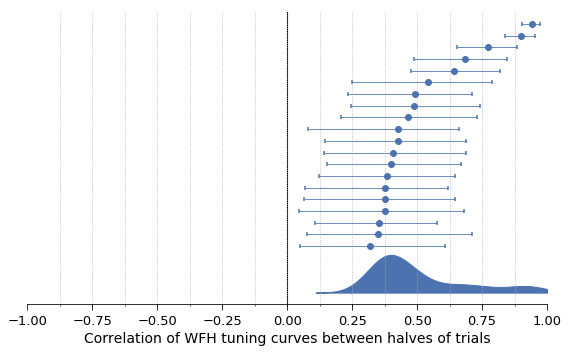

In [214]:
plot_corr_scatter_control(mean_corrs, lows, highs,f=.2, lower=-1, savename="wfh_split_trial_all")

In [210]:
!ls final_figures/

artificial_TC_on_nat_images_pr2.pdf  pr2_scatter_vgg_xgb.pdf
new_error_hist-glm_lowreg-art..pdf   VGG_halves_control.pdf
new_error_hist-glm_lowreg-VGG.pdf    VGG_modulation_vs_MI.pdf
new_error_hist-glm_lowreg-xgb.pdf    VGG_pr2_vs_corr.pdf
new_error_hist-VGG-art..pdf	     wfh_split_trial_all.pdf
new_error_hist-xgb-art..pdf	     XGB_control_with_bound.pdf
new_error_hist-xgb-VGG.pdf	     XGB_halves_control_M4.pdf
pr2_scatter_glm_xgb.pdf


In [146]:
# only select neurons whose WFH TCs we can reliably reconstruct
which_wfh_bool = lows>0
which_wfh = np.arange(80)[which_wfh_bool]
which_wfh

array([12, 18, 19, 21, 22, 36, 40, 42, 50, 51, 53, 55, 56, 58, 61, 62, 64,
       67, 71, 73])

In [229]:
def fit_all_methods_on_halves():
#     nat_hist_glm_lowreg = prep_data_and_fit_neurons_M4(df_neurons, nat_df, model='GLM_poisson', session = 'nat', 
#               nat_features = sat_nat_features, image_feature = 'hue.histogram', name = 'glm_lowreg', lambd='min',
#               verbose = 0, plot=False, which_neurons = 'all',joint=True, fit_on_halves = True,resample = True)  
    nat_hist_XGB = prep_data_and_fit_neurons_M4(df_neurons, nat_df, model='XGB_poisson', session = 'nat', 
                  nat_features = sat_nat_features, image_feature = 'hue.histogram', name = 'xgb', resample = True,
                  verbose = 0, plot=False, which_neurons = 'all',joint=True, fit_on_halves = True)
    

#     all_methods = /.join()
    
    return nat_hist_XGB

In [232]:
# fit_halves = [fit_all_methods_on_halves()]
# then resample
n=90

for i in range(n):
    print(i)
    a = fit_all_methods_on_halves()
    fit_halves.append(a)




0it [00:00, ?it/s]

0




1it [00:16, 16.63s/it]

2it [00:31, 16.18s/it]

3it [00:45, 15.58s/it]

4it [00:55, 13.81s/it]

5it [01:12, 14.63s/it]

6it [01:26, 14.69s/it]

7it [01:41, 14.65s/it]

8it [01:58, 15.30s/it]

9it [02:08, 13.73s/it]

10it [02:28, 15.70s/it]

11it [02:46, 16.23s/it]

12it [03:04, 16.85s/it]

13it [03:15, 15.08s/it]

14it [03:29, 14.77s/it]

15it [03:44, 14.94s/it]

16it [04:01, 15.48s/it]

17it [04:15, 14.90s/it]

18it [04:29, 14.74s/it]

19it [04:43, 14.46s/it]

20it [04:51, 12.62s/it]

21it [05:03, 12.49s/it]

22it [05:18, 13.15s/it]

23it [05:27, 12.00s/it]

24it [05:38, 11.73s/it]

25it [05:49, 11.36s/it]

26it [05:59, 10.95s/it]

27it [06:07, 10.14s/it]

28it [06:18, 10.32s/it]

29it [06:33, 11.78s/it]

30it [06:45, 11.90s/it]

31it [07:00, 12.66s/it]

32it [07:15, 13.60s/it]

33it [07:30, 13.87s/it]

34it [07:45, 14.20s/it]

35it [08:00, 14.54s/it]

36it [08:15, 14.55s/it]

37it [08:28, 14.09s/it]

38it [08:42, 14.24s/it]

39it [09:00, 15.18s/it]

40it [09:15, 15.27s/it]

41it [0

1




1it [00:15, 15.76s/it]

2it [00:28, 14.95s/it]

3it [00:44, 15.09s/it]

4it [00:56, 14.36s/it]

5it [01:12, 14.61s/it]

6it [01:27, 14.82s/it]

7it [01:42, 14.96s/it]

8it [01:58, 15.14s/it]

9it [02:13, 15.10s/it]

10it [02:28, 15.17s/it]

11it [02:44, 15.26s/it]

12it [02:59, 15.36s/it]

13it [03:11, 14.40s/it]

14it [03:22, 13.34s/it]

15it [03:32, 12.32s/it]

16it [03:45, 12.39s/it]

17it [04:02, 13.80s/it]

18it [04:25, 16.68s/it]

19it [04:41, 16.38s/it]

20it [04:51, 14.53s/it]

21it [05:03, 13.67s/it]

22it [05:12, 12.41s/it]

23it [05:21, 11.37s/it]

24it [05:31, 10.80s/it]

25it [05:40, 10.45s/it]

26it [05:49,  9.95s/it]

27it [05:59, 10.04s/it]

28it [06:15, 11.63s/it]

29it [06:29, 12.44s/it]

30it [06:42, 12.51s/it]

31it [06:58, 13.80s/it]

32it [07:13, 13.98s/it]

33it [07:27, 14.01s/it]

34it [07:38, 13.08s/it]

35it [07:47, 11.79s/it]

36it [07:57, 11.28s/it]

37it [08:09, 11.62s/it]

38it [08:18, 10.90s/it]

39it [08:32, 11.89s/it]

40it [08:47, 12.53s/it]

41it [0

2




1it [00:09,  9.20s/it]

2it [00:23, 10.87s/it]

3it [00:34, 10.68s/it]

4it [00:48, 11.85s/it]

5it [01:06, 13.47s/it]

6it [01:15, 12.42s/it]

7it [01:25, 11.64s/it]

8it [01:35, 11.11s/it]

9it [01:44, 10.56s/it]

10it [01:59, 11.61s/it]

11it [02:14, 12.88s/it]

12it [02:27, 12.84s/it]

13it [02:35, 11.48s/it]

14it [02:45, 10.85s/it]

15it [02:57, 11.11s/it]

16it [03:07, 10.83s/it]

17it [03:15, 10.22s/it]

18it [03:24,  9.80s/it]

19it [03:41, 11.96s/it]

20it [03:52, 11.59s/it]

21it [04:02, 11.17s/it]

22it [04:12, 10.84s/it]

23it [04:25, 11.47s/it]

24it [04:38, 11.94s/it]

25it [04:53, 12.76s/it]

26it [05:05, 12.61s/it]

27it [05:14, 11.49s/it]

28it [05:24, 10.89s/it]

29it [05:32, 10.05s/it]

30it [05:43, 10.50s/it]

31it [05:52,  9.96s/it]

32it [06:02, 10.05s/it]

33it [06:12,  9.94s/it]

34it [06:24, 10.72s/it]

35it [06:38, 11.45s/it]

36it [06:53, 12.69s/it]

37it [07:07, 12.92s/it]

38it [07:17, 12.17s/it]

39it [07:31, 12.76s/it]

40it [07:45, 13.08s/it]

41it [0

3




1it [00:10, 10.83s/it]

2it [00:19, 10.31s/it]

3it [00:38, 12.83s/it]

4it [00:47, 11.64s/it]

5it [00:55, 10.63s/it]

6it [01:11, 12.05s/it]

7it [01:23, 12.24s/it]

8it [01:36, 12.33s/it]

9it [01:49, 12.55s/it]

10it [02:03, 13.03s/it]

11it [02:22, 14.93s/it]

12it [02:42, 16.30s/it]

13it [02:56, 15.67s/it]

14it [03:11, 15.57s/it]

15it [03:21, 13.60s/it]

16it [03:31, 12.59s/it]

17it [03:44, 12.81s/it]

18it [03:59, 13.45s/it]

19it [04:07, 11.83s/it]

20it [04:29, 14.84s/it]

21it [04:45, 15.14s/it]

22it [04:58, 14.48s/it]

23it [05:10, 13.87s/it]

24it [05:23, 13.67s/it]

25it [05:39, 14.37s/it]

26it [05:48, 12.69s/it]

27it [05:58, 11.92s/it]

28it [06:10, 12.01s/it]

29it [06:21, 11.58s/it]

30it [06:30, 10.70s/it]

31it [06:44, 11.65s/it]

32it [06:56, 11.89s/it]

33it [07:14, 13.75s/it]

34it [07:25, 12.78s/it]

35it [07:34, 11.74s/it]

36it [07:49, 12.73s/it]

37it [08:01, 12.50s/it]

38it [08:14, 12.78s/it]

39it [08:31, 13.99s/it]

40it [08:48, 14.72s/it]

41it [0

4




1it [00:12, 12.35s/it]

2it [00:25, 12.69s/it]

3it [00:41, 13.62s/it]

4it [00:54, 13.37s/it]

5it [01:10, 14.07s/it]

6it [01:24, 14.21s/it]

7it [01:39, 14.26s/it]

8it [01:53, 14.40s/it]

9it [02:08, 14.61s/it]

10it [02:24, 14.79s/it]

11it [02:40, 15.21s/it]

12it [03:06, 18.54s/it]

13it [03:28, 19.44s/it]

14it [03:42, 17.92s/it]

15it [03:56, 16.75s/it]

16it [04:10, 16.02s/it]

17it [04:23, 15.17s/it]

18it [04:39, 15.27s/it]

19it [04:55, 15.39s/it]

20it [05:08, 14.67s/it]

21it [05:21, 14.13s/it]

22it [05:32, 13.42s/it]

23it [05:45, 13.14s/it]

24it [05:58, 13.27s/it]

25it [06:13, 13.68s/it]

26it [06:27, 13.85s/it]

27it [06:42, 14.11s/it]

28it [06:57, 14.38s/it]

29it [07:13, 14.85s/it]

30it [07:26, 14.18s/it]

31it [07:32, 12.01s/it]

32it [07:46, 12.53s/it]

33it [08:00, 12.95s/it]

34it [08:13, 12.99s/it]

35it [08:21, 11.35s/it]

36it [08:29, 10.39s/it]

37it [08:35,  9.18s/it]

38it [08:43,  8.65s/it]

39it [08:50,  8.13s/it]

40it [08:57,  8.06s/it]

41it [0

5




1it [00:11, 11.79s/it]

2it [00:25, 12.35s/it]

3it [00:37, 12.21s/it]

4it [00:49, 12.18s/it]

5it [01:02, 12.46s/it]

6it [01:15, 12.72s/it]

7it [01:23, 11.32s/it]

8it [01:35, 11.54s/it]

9it [01:51, 12.72s/it]

10it [02:07, 13.67s/it]

11it [02:22, 14.14s/it]

12it [02:37, 14.37s/it]

13it [02:49, 13.51s/it]

14it [03:03, 13.87s/it]

15it [03:18, 14.23s/it]

16it [03:34, 14.62s/it]

17it [03:47, 14.28s/it]

18it [04:02, 14.56s/it]

19it [04:13, 13.47s/it]

20it [04:22, 12.03s/it]

21it [04:31, 11.00s/it]

22it [04:39, 10.16s/it]

23it [04:48,  9.99s/it]

24it [04:59, 10.18s/it]

25it [05:29, 16.05s/it]

26it [05:58, 19.93s/it]

27it [06:26, 22.46s/it]

28it [06:54, 24.10s/it]

29it [07:10, 21.52s/it]

30it [07:35, 22.56s/it]

31it [07:54, 21.56s/it]

32it [08:10, 19.81s/it]

33it [08:25, 18.49s/it]

34it [08:40, 17.38s/it]

35it [08:54, 16.58s/it]

36it [09:09, 15.95s/it]

37it [09:22, 14.95s/it]

38it [09:36, 14.80s/it]

39it [09:51, 14.89s/it]

40it [10:06, 14.95s/it]

41it [1

6




1it [00:10, 10.60s/it]

2it [00:19, 10.14s/it]

3it [00:29, 10.02s/it]

4it [00:38,  9.68s/it]

5it [00:48,  9.74s/it]

6it [00:58,  9.80s/it]

7it [01:08,  9.93s/it]

8it [01:19, 10.27s/it]

9it [01:30, 10.49s/it]

10it [01:41, 10.60s/it]

11it [01:51, 10.44s/it]

12it [02:01, 10.32s/it]

13it [02:14, 11.05s/it]

14it [02:28, 12.11s/it]

15it [02:43, 12.79s/it]

16it [02:57, 13.36s/it]

17it [03:10, 13.18s/it]

18it [03:24, 13.46s/it]

19it [03:40, 14.04s/it]

20it [03:53, 13.78s/it]

21it [04:05, 13.47s/it]

22it [04:18, 13.24s/it]

23it [04:37, 15.05s/it]

24it [04:59, 16.94s/it]

25it [05:20, 18.27s/it]

26it [05:42, 19.40s/it]

27it [06:04, 20.21s/it]

28it [06:26, 20.70s/it]

29it [06:49, 21.35s/it]

30it [07:08, 20.51s/it]

31it [07:27, 20.30s/it]

32it [07:38, 17.30s/it]

33it [07:48, 15.13s/it]

34it [08:02, 14.97s/it]

35it [08:16, 14.61s/it]

36it [08:30, 14.54s/it]

37it [08:42, 13.68s/it]

38it [08:56, 13.65s/it]

39it [09:10, 13.93s/it]

40it [09:25, 14.01s/it]

41it [0

7




1it [00:15, 15.24s/it]

2it [00:28, 14.67s/it]

3it [00:43, 14.78s/it]

4it [00:56, 14.07s/it]

5it [01:15, 15.70s/it]

6it [01:34, 16.72s/it]

7it [01:44, 14.67s/it]

8it [01:59, 14.69s/it]

9it [02:14, 14.74s/it]

10it [02:29, 14.82s/it]

11it [02:43, 14.78s/it]

12it [02:59, 14.93s/it]

13it [03:11, 14.17s/it]

14it [03:25, 14.24s/it]

15it [03:40, 14.35s/it]

16it [03:55, 14.55s/it]

17it [04:09, 14.51s/it]

18it [04:24, 14.57s/it]

19it [04:39, 14.77s/it]

20it [04:53, 14.43s/it]

21it [05:06, 14.05s/it]

22it [05:18, 13.39s/it]

23it [05:31, 13.15s/it]

24it [05:44, 13.23s/it]

25it [05:58, 13.42s/it]

26it [06:12, 13.65s/it]

27it [06:26, 13.76s/it]

28it [06:41, 14.12s/it]

29it [06:56, 14.35s/it]

30it [07:08, 13.67s/it]

31it [07:21, 13.36s/it]

32it [07:36, 13.98s/it]

33it [07:57, 15.96s/it]

34it [08:17, 17.23s/it]

35it [08:37, 18.18s/it]

36it [08:58, 18.99s/it]

37it [09:13, 17.75s/it]

38it [09:32, 18.18s/it]

39it [09:53, 18.89s/it]

40it [10:13, 19.44s/it]

41it [1

8




1it [00:15, 15.26s/it]

2it [00:28, 14.68s/it]

3it [00:42, 14.45s/it]

4it [00:51, 12.86s/it]

5it [01:01, 11.97s/it]

6it [01:11, 11.38s/it]

7it [01:22, 11.15s/it]

8it [01:32, 10.97s/it]

9it [01:43, 10.84s/it]

10it [01:53, 10.72s/it]

11it [02:03, 10.32s/it]

12it [02:12,  9.99s/it]

13it [02:21,  9.61s/it]

14it [02:31,  9.77s/it]

15it [02:40,  9.72s/it]

16it [02:50,  9.76s/it]

17it [03:08, 12.10s/it]

18it [03:27, 14.40s/it]

19it [03:48, 16.19s/it]

20it [04:02, 15.46s/it]

21it [04:15, 14.82s/it]

22it [04:28, 14.37s/it]

23it [04:42, 14.09s/it]

24it [04:56, 14.16s/it]

25it [05:11, 14.37s/it]

26it [05:26, 14.67s/it]

27it [05:41, 14.76s/it]

28it [05:59, 15.60s/it]

29it [06:16, 16.05s/it]

30it [06:28, 14.95s/it]

31it [06:35, 12.59s/it]

32it [06:43, 11.13s/it]

33it [06:57, 11.85s/it]

34it [07:12, 12.80s/it]

35it [07:26, 13.36s/it]

36it [07:40, 13.55s/it]

37it [07:52, 12.96s/it]

38it [08:06, 13.18s/it]

39it [08:20, 13.59s/it]

40it [08:35, 13.94s/it]

41it [0

46




1it [00:09,  9.83s/it]

2it [00:18,  9.38s/it]

3it [00:28,  9.81s/it]

4it [00:38,  9.72s/it]

5it [00:49, 10.18s/it]

6it [01:02, 10.94s/it]

7it [01:16, 11.98s/it]

8it [01:31, 12.68s/it]

9it [01:46, 13.35s/it]

10it [02:00, 13.73s/it]

11it [02:16, 14.25s/it]

12it [02:30, 14.19s/it]

13it [02:42, 13.66s/it]

14it [02:57, 14.08s/it]

15it [03:08, 13.24s/it]

16it [03:17, 11.82s/it]

17it [03:27, 11.25s/it]

18it [03:43, 12.70s/it]

19it [03:56, 12.71s/it]

20it [04:05, 11.62s/it]

21it [04:14, 11.03s/it]

22it [04:23, 10.34s/it]

23it [04:38, 11.55s/it]

24it [04:51, 12.12s/it]

25it [05:00, 11.07s/it]

26it [05:09, 10.60s/it]

27it [05:25, 12.06s/it]

28it [05:38, 12.45s/it]

29it [05:49, 12.15s/it]

30it [05:58, 11.10s/it]

31it [06:07, 10.59s/it]

32it [06:18, 10.53s/it]

33it [06:30, 10.89s/it]

34it [06:41, 11.04s/it]

35it [06:54, 11.59s/it]

36it [07:06, 11.66s/it]

37it [07:16, 11.23s/it]

38it [07:27, 11.14s/it]

39it [07:38, 11.11s/it]

40it [07:54, 12.53s/it]

41it [0

47




1it [00:14, 14.67s/it]

2it [00:27, 14.18s/it]

3it [00:42, 14.43s/it]

4it [00:55, 13.84s/it]

5it [01:05, 12.86s/it]

6it [01:16, 12.37s/it]

7it [01:32, 13.27s/it]

8it [01:46, 13.68s/it]

9it [02:02, 14.12s/it]

10it [02:17, 14.43s/it]

11it [02:32, 14.64s/it]

12it [02:47, 14.71s/it]

13it [02:59, 13.84s/it]

14it [03:17, 15.36s/it]

15it [03:36, 16.35s/it]

16it [03:55, 17.05s/it]

17it [04:12, 17.21s/it]

18it [04:32, 17.82s/it]

19it [04:51, 18.39s/it]

20it [05:09, 18.27s/it]

21it [05:19, 15.58s/it]

22it [05:31, 14.57s/it]

23it [05:43, 13.95s/it]

24it [05:57, 13.72s/it]

25it [06:11, 13.93s/it]

26it [06:25, 14.00s/it]

27it [06:40, 14.20s/it]

28it [06:54, 14.31s/it]

29it [07:10, 14.69s/it]

30it [07:22, 13.92s/it]

31it [07:36, 13.77s/it]

32it [07:50, 14.08s/it]

33it [08:13, 16.65s/it]

34it [08:34, 18.04s/it]

35it [08:56, 19.10s/it]

36it [09:18, 19.97s/it]

37it [09:36, 19.33s/it]

38it [09:56, 19.67s/it]

39it [10:18, 20.45s/it]

40it [10:41, 20.96s/it]

41it [1

48




1it [00:12, 12.09s/it]

2it [00:23, 11.78s/it]

3it [00:35, 12.01s/it]

4it [00:46, 11.55s/it]

5it [01:01, 12.73s/it]

6it [01:13, 12.56s/it]

7it [01:25, 12.39s/it]

8it [01:40, 12.99s/it]

9it [01:52, 12.64s/it]

10it [02:03, 12.27s/it]

11it [02:19, 13.39s/it]

12it [02:39, 15.33s/it]

13it [02:57, 16.26s/it]

14it [03:20, 18.10s/it]

15it [03:41, 19.23s/it]

16it [04:03, 19.93s/it]

17it [04:17, 18.20s/it]

18it [04:33, 17.52s/it]

19it [04:49, 17.00s/it]

20it [05:02, 15.96s/it]

21it [05:15, 15.04s/it]

22it [05:28, 14.42s/it]

23it [05:42, 14.09s/it]

24it [05:55, 14.00s/it]

25it [06:10, 14.21s/it]

26it [06:25, 14.28s/it]

27it [06:39, 14.47s/it]

28it [06:51, 13.69s/it]

29it [07:06, 13.98s/it]

30it [07:18, 13.52s/it]

31it [07:31, 13.21s/it]

32it [07:45, 13.57s/it]

33it [08:00, 14.00s/it]

34it [08:27, 17.69s/it]

35it [08:42, 16.92s/it]

36it [08:57, 16.30s/it]

37it [09:09, 15.14s/it]

38it [09:23, 14.89s/it]

39it [09:39, 15.04s/it]

40it [09:50, 13.85s/it]

41it [0

49




1it [00:15, 15.24s/it]

2it [00:28, 14.67s/it]

3it [00:43, 14.89s/it]

4it [00:55, 13.89s/it]

5it [01:11, 14.48s/it]

6it [01:26, 14.67s/it]

7it [01:41, 14.81s/it]

8it [01:56, 14.85s/it]

9it [02:11, 14.80s/it]

10it [02:25, 14.75s/it]

11it [02:39, 14.28s/it]

12it [02:51, 13.63s/it]

13it [03:00, 12.24s/it]

14it [03:09, 11.39s/it]

15it [03:24, 12.39s/it]

16it [03:40, 13.54s/it]

17it [03:56, 14.30s/it]

18it [04:12, 14.87s/it]

19it [04:29, 15.41s/it]

20it [04:41, 14.41s/it]

21it [04:55, 14.24s/it]

22it [05:08, 13.88s/it]

23it [05:21, 13.59s/it]

24it [05:34, 13.58s/it]

25it [05:49, 13.73s/it]

26it [05:58, 12.57s/it]

27it [06:09, 12.12s/it]

28it [06:25, 13.04s/it]

29it [06:39, 13.43s/it]

30it [06:48, 11.96s/it]

31it [06:56, 10.87s/it]

32it [07:10, 11.94s/it]

33it [07:19, 10.84s/it]

34it [07:28, 10.29s/it]

35it [07:35,  9.53s/it]

36it [07:44,  9.39s/it]

37it [07:53,  9.05s/it]

38it [08:02,  9.07s/it]

39it [08:09,  8.63s/it]

40it [08:29, 11.92s/it]

41it [0

55




1it [00:13, 13.72s/it]

2it [00:27, 13.67s/it]

3it [00:42, 14.02s/it]

4it [00:51, 12.65s/it]

5it [01:02, 12.09s/it]

6it [01:13, 11.77s/it]

7it [01:27, 12.33s/it]

8it [01:42, 13.30s/it]

9it [01:57, 13.85s/it]

10it [02:13, 14.36s/it]

11it [02:24, 13.38s/it]

12it [02:38, 13.70s/it]

13it [02:50, 13.24s/it]

14it [03:02, 12.58s/it]

15it [03:12, 12.10s/it]

16it [03:29, 13.55s/it]

17it [03:39, 12.43s/it]

18it [03:52, 12.47s/it]

19it [04:05, 12.79s/it]

20it [04:14, 11.68s/it]

21it [04:25, 11.39s/it]

22it [04:37, 11.60s/it]

23it [04:45, 10.51s/it]

24it [04:54, 10.01s/it]

25it [05:05, 10.21s/it]

26it [05:19, 11.44s/it]

27it [05:35, 12.76s/it]

28it [05:53, 14.27s/it]

29it [06:09, 14.87s/it]

30it [06:21, 14.15s/it]

31it [06:36, 14.37s/it]

32it [06:54, 15.28s/it]

33it [07:08, 15.09s/it]

34it [07:19, 13.87s/it]

35it [07:35, 14.39s/it]

36it [07:46, 13.34s/it]

37it [07:54, 11.65s/it]

38it [08:02, 10.79s/it]

39it [08:18, 12.39s/it]

40it [08:33, 13.09s/it]

41it [0

56




1it [00:20, 20.76s/it]

2it [00:37, 19.60s/it]

3it [00:57, 19.59s/it]

4it [01:14, 18.80s/it]

5it [01:34, 19.30s/it]

6it [01:54, 19.40s/it]

7it [02:14, 19.76s/it]

8it [02:35, 19.91s/it]

9it [02:54, 19.63s/it]

10it [03:13, 19.53s/it]

11it [03:32, 19.38s/it]

12it [03:52, 19.50s/it]

13it [04:07, 18.28s/it]

14it [04:25, 18.30s/it]

15it [04:45, 18.56s/it]

16it [05:04, 18.69s/it]

17it [05:22, 18.55s/it]

18it [05:41, 18.65s/it]

19it [05:59, 18.50s/it]

20it [06:15, 17.73s/it]

21it [06:28, 16.34s/it]

22it [06:37, 14.17s/it]

23it [06:46, 12.61s/it]

24it [06:58, 12.34s/it]

25it [07:10, 12.36s/it]

26it [07:23, 12.44s/it]

27it [07:35, 12.51s/it]

28it [07:55, 14.78s/it]

29it [08:16, 16.59s/it]

30it [08:33, 16.55s/it]

31it [08:50, 16.82s/it]

32it [09:03, 15.72s/it]

33it [09:17, 14.95s/it]

34it [09:30, 14.39s/it]

35it [09:41, 13.64s/it]

36it [09:55, 13.60s/it]

37it [10:06, 12.71s/it]

38it [10:17, 12.44s/it]

39it [10:33, 13.31s/it]

40it [10:48, 13.83s/it]

41it [1

57




1it [00:15, 15.11s/it]

2it [00:26, 13.97s/it]

3it [00:39, 13.71s/it]

4it [00:53, 13.87s/it]

5it [01:07, 13.77s/it]

6it [01:27, 15.66s/it]

7it [01:45, 16.42s/it]

8it [01:59, 15.58s/it]

9it [02:14, 15.60s/it]

10it [02:30, 15.51s/it]

11it [02:44, 15.05s/it]

12it [02:58, 14.74s/it]

13it [03:10, 13.96s/it]

14it [03:26, 14.51s/it]

15it [03:41, 14.69s/it]

16it [03:55, 14.59s/it]

17it [04:09, 14.36s/it]

18it [04:24, 14.55s/it]

19it [04:39, 14.70s/it]

20it [04:52, 14.35s/it]

21it [05:07, 14.31s/it]

22it [05:22, 14.49s/it]

23it [05:37, 14.90s/it]

24it [05:53, 15.06s/it]

25it [06:08, 15.08s/it]

26it [06:22, 14.85s/it]

27it [06:37, 14.67s/it]

28it [06:51, 14.53s/it]

29it [07:05, 14.38s/it]

30it [07:17, 13.62s/it]

31it [07:28, 13.05s/it]

32it [07:46, 14.30s/it]

33it [08:00, 14.36s/it]

34it [08:15, 14.48s/it]

35it [08:30, 14.78s/it]

36it [08:42, 13.71s/it]

37it [08:50, 12.10s/it]

38it [09:00, 11.46s/it]

39it [09:14, 12.25s/it]

40it [09:28, 12.93s/it]

41it [0

61




1it [00:08,  8.70s/it]

2it [00:16,  8.39s/it]

3it [00:28,  9.63s/it]

4it [00:38,  9.50s/it]

5it [00:49, 10.09s/it]

6it [01:03, 11.23s/it]

7it [01:16, 11.72s/it]

8it [01:29, 12.17s/it]

9it [01:43, 12.71s/it]

10it [01:59, 13.80s/it]

11it [02:14, 13.91s/it]

12it [02:31, 14.84s/it]

13it [02:39, 12.79s/it]

14it [02:48, 11.82s/it]

15it [02:57, 11.02s/it]

16it [03:13, 12.50s/it]

17it [03:23, 11.76s/it]

18it [03:33, 11.32s/it]

19it [03:44, 11.11s/it]

20it [03:53, 10.47s/it]

21it [04:02, 10.05s/it]

22it [04:16, 11.10s/it]

23it [04:29, 11.70s/it]

24it [04:41, 11.74s/it]

25it [04:52, 11.49s/it]

26it [05:09, 13.21s/it]

27it [05:24, 13.67s/it]

28it [05:35, 13.11s/it]

29it [05:47, 12.65s/it]

30it [05:57, 11.93s/it]

31it [06:08, 11.70s/it]

32it [06:21, 11.88s/it]

33it [06:33, 12.07s/it]

34it [06:43, 11.35s/it]

35it [06:53, 10.98s/it]

36it [07:03, 10.77s/it]

KeyboardInterrupt: 

In [233]:
len(fit_halves)

68

In [234]:
pickle.dump(fit_halves, open("fit_halves_XGB_M4.p","wb"))

In [235]:
def CI_along_axis0(yy):
    """This returns the 5 and 95% CI for a matrix, over the first index. Not the mean - the CI on the value"""
    # each row is a new run; each column a neuron. So we want to sort over runs
   
    means = np.sort(yy, axis=0)
    if np.any(np.isnan(means)):
        last = np.where(np.isnan(means))[0][0]
        means = means[:last]
    l = len(means)
    # then re
    crit05 = means[l//20]
    crit95 = means[19*l//20]
    return crit05,crit95

def get_CI_for_NS_halves_correlations(fit_halves, method, which_neurons='all'):
    mean_corrs = []
    lows = []
    highs = []
    for neuron_id in range(80):
        if not (which_neurons == 'all') and not (neuron_id in which_neurons):
            continue
        corr_list = []
        for nc in range(len(fit_halves)):
            # these are the two curves
            plain_predicted1 = fit_halves[nc][method][neuron_id]['plain_predicted_spike_counts_half1']
            plain_predicted2 = fit_halves[nc][method][neuron_id]['plain_predicted_spike_counts_half2']
            hues = fit_halves[nc][method][neuron_id]['plain_hue']
            
            #now bin
            bin_means1, bin_edges1, binnumber1 = stats.binned_statistic(hues,plain_predicted1, bins = 16)
            bin_means2, bin_edges1, binnumber1 = stats.binned_statistic(hues,plain_predicted2, bins = 16)
            hues = bin_edges1[1:] - (bin_edges1[1] - bin_edges1[0])/2
            # now correlate
            this_corr_coef = np.corrcoef(bin_means1, bin_means2)[0,1]
            corr_list.append(this_corr_coef)

        # now get the CI
        low,high = CI_along_axis0(corr_list)
        mean_corrs.append(np.nanmean(corr_list))
        lows.append(low)
        highs.append(high)
    
    return np.array(mean_corrs), np.array(lows), np.array(highs)

def plot_corr_scatter_control(mean_corrs, lows, highs, savename=False, color=None,percentile =5,ybins = 16.,f = 3,
    xbins = 16.,    lower=-8, label="WFH"):

    print("Population mean of {} {}".format(np.nanmean(mean_corrs),
                                            CI_along_axis0(mean_corrs)))
     
    if color == None:
        color = sns.color_palette(n_colors=3)[0]
    plt.figure(figsize=(8,5))
   
    y = np.argsort(mean_corrs)
    print("Worst 5 neurons: ",y[:5])
    
    plt.errorbar(mean_corrs[y],f*np.arange(len(y)), fmt= 'o',
        xerr = [mean_corrs[y]-lows[y], highs[y]-mean_corrs[y]],
       elinewidth = .8, capsize=2,capthick=1.5, color=color)

# #     special neurons
#     plt.errorbar(mean[17:19],[np.argwhere(y==17)[0,0],np.argwhere(y==18)[0,0]], fmt= 'o',
#         xerr = [mean[17:19]-low[17:19], high[17:19]-mean[17:19]],
#        elinewidth = .8, capsize=2,capthick=1.5, color='orange',zorder=3)

    ax = plt.gca()
    plt.xlim([-1,1])
   
    
    
    # the grid lines
    ax.set_xticks(np.arange(-1+2/xbins,1,2/xbins, ), minor=True)
    ax.axvline(ymin=lower, ymax = len(mean_corrs), c='k', zorder = 0, linewidth = 1.1)
    plt.grid(which = 'minor', linestyle=':')


    plt.xticks(fontsize= 13)
    plt.xlabel('Correlation of {} tuning curves between halves of trials'.format(label), fontsize=14)


    simpleaxis(ax)
    ax.spines['left'].set_visible(False)
    plt.yticks([])

    # the lower density plot
    
    ax = sns.kdeplot(mean_corrs,shade=True,ax=ax, color='w',bw=.07 ,zorder=0,)
    
    
    plt.ylim(lower-1
             ,f*len(y))
    line = ax.get_lines()[-1]
    x, y = line.get_data()
    
    ax.fill_between(x, y1=lower+y, y2=lower, alpha=1, color = color)
    
    plt.tight_layout()
    if savename:
        plt.savefig("final_figures/{}.pdf".format(savename),format='pdf')
    plt.show()
    return ax

def plot_corr_scatter_with_bound(all_corrs, method1, method2,
                                 mean_corrs, low_corrs, high_corrs, bound = True,
                                 color = None,savename=False, percentile =5,
                                 which_idx ='all',lower=-8
                                ):
    all_corrs_for_these_two = all_corrs.loc[method1,method2]
    
    if not (which_idx is 'all'):
        all_corrs_for_these_two = all_corrs_for_these_two[:,which_idx]
    
    mean = np.nanmean(all_corrs_for_these_two,axis=0)
    try:
        low, high = CI_along_axis0_nan(all_corrs_for_these_two,percentile)
    except ValueError:
        method2,method1 = method1, method2
        all_corrs_for_these_two = all_corrs.loc[method1,method2]
        mean = np.nanmean(all_corrs_for_these_two,axis=0)
        low, high = CI_along_axis0_nan(all_corrs_for_these_two,percentile)
#         stds=np.nanstd(vals,axis=0)[:,i]*1.96
    if ('glm' in method1) or ('glm' in method2):
        good_GLM_neurons = ~np.isnan(mean)
        mean = mean[good_GLM_neurons]
        low = low[good_GLM_neurons]
        high = high[good_GLM_neurons]

    ybins = 16.
    xbins = 16.
    

    print("Population mean of {} {}".format(np.nanmean(all_corrs_for_these_two),
                                            bootstrap_nan(np.nanmean(all_corrs_for_these_two,axis=0))))
    
    plt.figure(figsize=(8,5))
    if color == None:
        color = sns.color_palette(n_colors=3)[0]
        
        
    

    y_jitter = 0.2*np.random.randn(len(mean))
    y = np.argsort(mean)
    plt.errorbar(mean[y],range(len(y)), fmt= 'o',
        xerr = [mean[y]-low[y], high[y]-mean[y]],
       elinewidth = .8, capsize=2,capthick=1.5, color = color)
    
    
        # the upper bounds
    if bound == True:
        plt.errorbar(mean_corrs[y],range(len(y)), fmt= 'o', color = 'orange')

    ax = plt.gca()

    plt.xlim([-1,1])
    # the grid lines
    ax.set_xticks(np.arange(-1+2/xbins,1,2/xbins, ), minor=True)
    ax.axvline(ymin=lower, ymax = len(mean), c='k', zorder = 0, linewidth = 1.1)
    plt.grid(which = 'minor', linestyle=':')


    plt.xticks(fontsize= 13)
    plt.xlabel('Tuning curve correlation', fontsize=14)


    simpleaxis(ax)
    ax.spines['left'].set_visible(False)
    plt.yticks([])

    # the lower density plot
    ax = sns.kdeplot(mean,shade=True,ax=ax, color='w',bw=.07 ,zorder=0)
    
    
    plt.ylim(lower-1
             ,len(y))
    line = ax.get_lines()[-1]
    x, y = line.get_data()
    
    ax.fill_between(x, y1=lower+y, y2=lower, alpha=1, facecolor=color)
    
    plt.tight_layout()
    if savename:
        plt.savefig("final_figures/{}.pdf".format(savename),format='pdf')
    plt.show()
    return ax

Population mean of 0.127242448337 (-0.029787882124583415, 0.32794442310586569)
('Worst 5 neurons: ', array([74, 44, 17, 65, 30]))


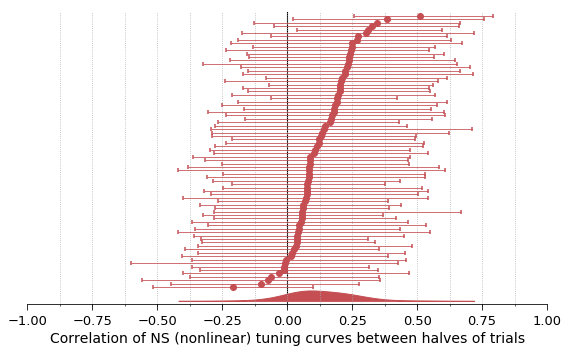

In [236]:
#all
mean_xgb, low_xgb, high_xgb = get_CI_for_NS_halves_correlations(fit_halves, 'xgb')
plot_corr_scatter_control(mean_xgb, low_xgb, high_xgb, color = sns.color_palette(n_colors=4)[3],f=1,lower = -4,
                          label="NS (nonlinear)", 
#                           savename ='XGB_halves_control_M4'
                         )

Population mean of 0.158567286351 (-0.0074998686186014572, 0.50956648197168519)
('Worst 5 neurons: ', array([15, 14,  2,  5,  9]))


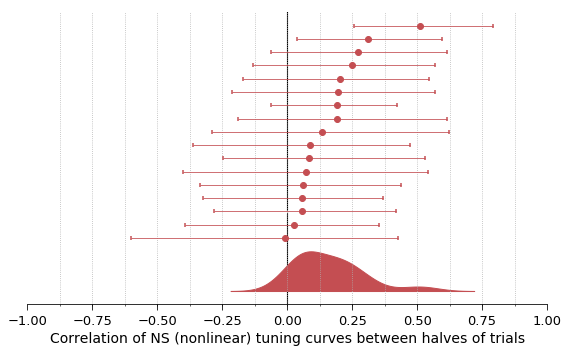

In [378]:
# just those with reconstructable WFHs
mean_xgb_split, low_xgb_split, high_xgb_split = get_CI_for_NS_halves_correlations(fit_halves, 'xgb',which_wfh_and_1Hz)
plot_corr_scatter_control(mean_xgb_split, low_xgb_split, high_xgb_split, color = sns.color_palette(n_colors=4)[3],f=1,lower = -4,
                          label="NS (nonlinear)", 
                          savename ='XGB_halves_control_M4_wfh'
                         )

In [149]:
which_wfh_in_which_neurons = [i for i,w in enumerate(which_neurons) if which_wfh_bool[w]]
which_wfh_in_which_neurons

[2, 6, 8, 9, 20, 23, 25, 29, 30, 31, 32, 33, 34, 35, 36, 37, 41]

In [162]:
which_wfh_and_1Hz = [i for i in which_wfh if i in which_neurons]

Population mean of 0.134295009351 [ 0.04579322  0.24217909]


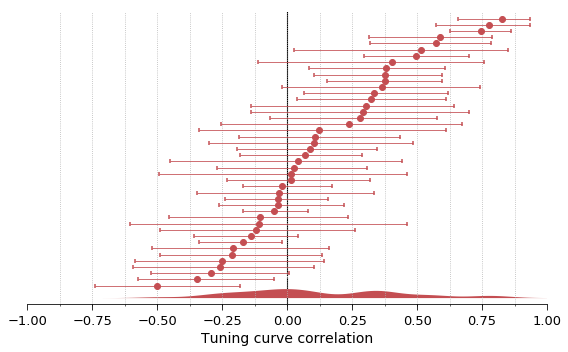

In [136]:
plot_corr_scatter_with_bound(all_corrs,'xgb','art.',
                mean_xgb, low_xgb, high_xgb,
                             which_idx = which_wfh,
                              bound = False,
                   color = sns.color_palette(n_colors=4)[3], lower = -2,
                   savename = "XGB_control_wf", percentile=5)

Population mean of 0.462214403213 (-0.22772222231136105, 0.99999958051941884)
('Worst 5 neurons: ', array([ 7, 10, 21,  4, 16]))


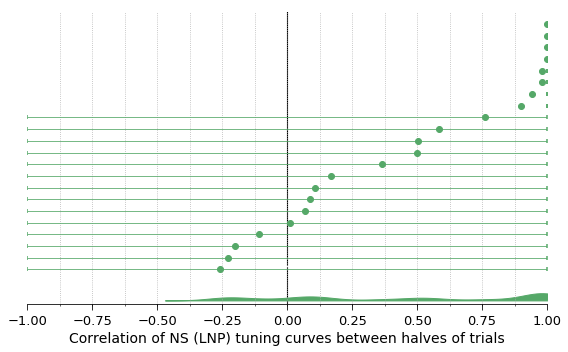

In [85]:
mean_glm, low_glm, high_glm = get_CI_for_NS_halves_correlations(fit_halves, 'glm_lowreg', which_neurons)
plot_corr_scatter_control(mean_glm, low_glm, high_glm, color = sns.color_palette(n_colors=4)[2],
                         label="NS (LNP)", #savename ='GLM_halves_control'
                         )

### And for VGG

In [25]:
diff_df_all_halves =  pd.DataFrame(pd.read_pickle('diff_df_2cv_M4.p'))


In [75]:
## now for the VGG methods
diff_df_all =  pd.read_pickle('diff_df_real_all.p')

In [28]:
skfs = pickle.load( open("skfs_m4.p","rb"))

In [186]:
def get_slopes_M4(neuron_id, diff_dataframe, nbins=8, ids='all', plot=False, resample = False,
                 sats = [0,.1, 0.2, 0.3, 0.4, .5, .6,0.7, 0.75, 0.8, 0.85, 0.9,0.95, 1]):
    slopes = []
    errs = []
    colors = []
    for hue in range(1,nbins+1):
        diffs = []
        stds=[]
        allpoints = []
        allsats = []
        
        for sat in sats[:-1]:
            a =diff_dataframe.loc[neuron_id,'vgg.l6.sat_'+str(sat)+'_bin_' + str(hue)]
            if not (ids is 'all'):
                a = a[ids]
##             remove outliers
#             a = a[a**2<100]  
            if resample:
                a = np.random.choice(a,len(a))
            diffs.append(a.mean())
            stds.append(a.std())
            allpoints.append(a)
            allsats.append(sat*np.ones(a.shape)) 

            

        allpoints = np.hstack(allpoints)
        allsats = 100*(1-np.hstack(allsats))
                
        # get slope
        res = sm.OLS(allpoints, allsats).fit()
        slope = res.params[0]
        err = res.conf_int()[0]
        
                
        diffs.append(0)
        stds.append(0)
        

        slopes.append(slope)
        errs.append(err)
        if plot:
            n = len(a)
            sats_, diffs, stds = (1-np.array(sats))*100,np.array(diffs), np.array(stds)/np.sqrt(n)

            h = (hue)/8.
            c =np.roll(sns.color_palette(palette = 'hls', n_colors=8, desat=1),4)[hue-1]

            plt.plot(sats_, diffs,'-o', c=c)
            plt.fill_between(sats_, diffs-stds, diffs+stds,alpha = 0.4, color = c)
            colors.append(c)
        
    if plot:
        simpleaxis(plt.gca())
        plt.xlabel('Percent Desaturated', fontsize = 16)    
        plt.ylabel('Average difference of predictions', fontsize = 16)
        plt.tight_layout()
    return np.array(slopes), np.array(errs)

In [187]:
def get_CI_for_NS_halves_correlations_VGG_M4(diff_df_all_halves,skfs,
                                             plot = False, n_iters = 100, which_neurons = range(80)):
    mean_corrs = []
    lows = []
    highs = []
    ii=-1
    for neuron_id in tqdm(range(80)):
        if neuron_id not in which_neurons:
            continue
        ii+=1
        skf = skfs[neuron_id]
        corr_list = []
                                       
        ids1,ids2 = list(skf)[0]
        # these are the two curves
        
        
        if plot:
            print("Neuron",neuron_id)

            plt.figure(figsize = (15,4))
            plt.subplot(131)
            slopes1, errs = get_slopes_M4(neuron_id, diff_df_all_halves, nbins = 8,
              sats = [0,.1, 0.2, 0.3, 0.4, .5, .6,0.7, 0.75, 0.8, 0.85, 0.9,0.95, 1],
              ids = 'all', 
              plot = True)
            plt.title("All half")
            plt.subplot(132)
            slopes1, errs1= get_slopes_M4(neuron_id, diff_df_all_halves, nbins = 8,
              sats = [0,.1, 0.2, 0.3, 0.4, .5, .6,0.7, 0.75, 0.8, 0.85, 0.9,0.95, 1],
              ids = ids2, 
              plot = True)
            plt.title("one half")
            plt.subplot(133)
            slopes, errs = get_slopes_M4(neuron_id, diff_df_all, nbins = 8,
              sats = [0,.1, 0.2, 0.3, 0.4, .5, .6,0.7, 0.75, 0.8, 0.85, 0.9,0.95, 1],
              plot = True)
            plt.tight_layout()
            plt.title("original ({})".format(which_neurons[ii]))
            plt.show()
                
        corr_list = []
        for n in range(n_iters):
            slopes1, errs1 = get_slopes_M4(neuron_id, diff_df_all_halves, nbins = 8,
              sats = [0,.1, 0.2, 0.3, 0.4, .5, .6,0.7, 0.75, 0.8, 0.85, 0.9,0.95, 1],
              ids = ids2,resample = True, 
              plot = False)


            slopes2, errs2 = get_slopes_M4(neuron_id, diff_df_all_halves, nbins = 8,
              sats = [0,.1, 0.2, 0.3, 0.4, .5, .6,0.7, 0.75, 0.8, 0.85, 0.9,0.95, 1],
              ids = ids1, resample = True)

            # now correlate
            this_corr_coef = np.corrcoef(slopes1, slopes2)[0,1]

            corr_list.append(this_corr_coef)

        # now get the CI
        low,high = CI_along_axis0(corr_list)
        mean_corrs.append(np.nanmean(corr_list))
        lows.append(low)
        highs.append(high)
        
    
    return np.array(mean_corrs), np.array(lows), np.array(highs)

In [216]:
mean_vgg_split, low_vgg_split, high_vgg_split = get_CI_for_NS_halves_correlations_VGG_M4(diff_df_all_halves, skfs, plot=False,
                                                                      which_neurons = which_neurons)

 31%|███▏      | 25/80 [01:55<07:27,  8.13s/it]

KeyboardInterrupt: 

Population mean of 0.193131803175 (-0.47764514379802753, 0.92334338802625138)
('Worst 5 neurons: ', array([ 4,  2, 15, 11, 16]))


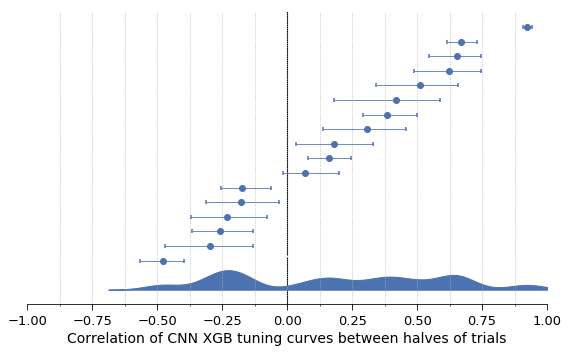

In [223]:
plot_corr_scatter_control(mean_vgg_split, low_vgg_split, high_vgg_split, #color = sns.color_palette(n_colors=4)[3],
                          label="CNN XGB", savename ='VGG_split_halves_all',
                         f=1,lower=-2)

## Get the correlations between tuning curves

In [87]:
diff_df_all_real =  pd.read_pickle('diff_df_real_all.p')

sats = [0,.1, 0.2, 0.3, 0.4, .5, .6,0.7, 0.75, 0.8, 0.85, 0.9,0.95, 1] # end with 1
# sats = [0,1]
nbins = 8


In [193]:
def get_all_corrs_resample(bootstrapped_fits, which_neurons):
    """Create a matrix where each entry contains a list neurons, and each element is an array
    of shape (num_fits, n_neurons)
    """
    nbins = 8
    n_neurons = len(which_neurons)

    methods = list(bootstrapped_fits[0].columns) + ['VGG','art.']
    
    all_corrs = pd.DataFrame(index = methods, columns = methods, dtype=object)
    # initialize the corr_coef lists
    for i,method1 in enumerate(methods):
        for method2 in methods[i+1:]:
            all_corrs.loc[method1,method2] = np.zeros((len(bootstrapped_fits),n_neurons))
                
    hue = bootstrapped_fits[0].iloc[0].iloc[0]['plain_hue']
    for neuron_num,neuron_id in tqdm(enumerate(which_neurons)):        
        #### Get the VGG TCs ##### 
#         slopes, errs= get_slopes_M4(neuron_num, diff_df_all)
        
                
        #### Get the art. TCs #####
        
        x,y =  art_XGB.iloc[:,0][neuron_id]['hue'],\
                              art_XGB.iloc[:,0][neuron_id]['spike_counts']/\
                               art_XGB.iloc[:,0][neuron_id]['duration']
        x,y = bootstrap2(x,y)
        
        art_binned, _, _ = stats.binned_statistic(
                           x,y,
                              statistic='mean',bins = 8)
        
        for fit_num, single_fit in enumerate(bootstrapped_fits):
 
            # jitter around slopes
       
            slopes, errs = get_slopes_M4(neuron_num, diff_df_all, nbins = 8,
              sats = [0,.1, 0.2, 0.3, 0.4, .5, .6,0.7, 0.75, 0.8, 0.85, 0.9,0.95, 1],
              resample = True, 
              plot = False)


            #### Get the TCs for the other methods too ####
            for i,method in enumerate(methods):
                # Get the first curve...
                if method=='art.':
                    binned_TC1 = art_binned
                elif method == 'VGG':
                    binned_TC1 = slopes
                else:
                    predicted_response = single_fit.loc[neuron_id,method]['plain_predicted_spike_counts']
                    binned_TC1, _,_  = stats.binned_statistic(
                                                hue, predicted_response,
                                                statistic='mean',range = (-np.pi,np.pi),
                                                      bins = 8)  
                for method2 in methods[i+1:]:
                    # Get the second curve...
                    if method2=='art.':
                        binned_TC2 = art_binned
                    elif method2 == 'VGG':
                        binned_TC2 = slopes
                    else:
                        predicted_response = single_fit.loc[neuron_id,method2]['plain_predicted_spike_counts']
                        binned_TC2, _,_  = stats.binned_statistic(
                                                    hue, predicted_response,
                                                    statistic='mean',range = (-np.pi,np.pi),
                                                          bins = 8) 
                    # now correlate
                    this_corr_coef = np.corrcoef(binned_TC1, binned_TC2)[0,1]
#                     print(this_corr_coef,all_corrs.loc[method,method2])
                    # append to the proper list
                    all_corrs.loc[method,method2][fit_num,neuron_num]= this_corr_coef
    return all_corrs

In [330]:
def plot_corr_scatter(all_corrs, method1, method2,color = None,save=False, percentile =5,    lower=-8):
    all_corrs_for_these_two = all_corrs.loc[method1,method2]
    mean = np.nanmean(all_corrs_for_these_two,axis=0)
    try:
        low, high = CI_along_axis0_nan(all_corrs_for_these_two,percentile)
    except ValueError:
        method2,method1 = method1, method2
        all_corrs_for_these_two = all_corrs.loc[method1,method2]
        mean = np.nanmean(all_corrs_for_these_two,axis=0)
        low, high = CI_along_axis0_nan(all_corrs_for_these_two,percentile)
#         stds=np.nanstd(vals,axis=0)[:,i]*1.96
#     if ('glm' in method1) or ('glm' in method2):
#         good_GLM_neurons = ~np.isnan(mean)
#         mean = mean[good_GLM_neurons]
#         low = low[good_GLM_neurons]
#         high = high[good_GLM_neurons]

    ybins = 16.
    xbins = 16.

    print("Population mean of {} {}".format(np.nanmean(all_corrs_for_these_two),
                                            bootstrap_nan(np.nanmean(all_corrs_for_these_two,axis=0))))
    
    plt.figure(figsize=(8,4))
    if color == None:
        color = sns.color_palette(n_colors=3)[0]

    y = np.argsort(mean)
#     low = mean-.1
#     high = mean+.1
    
    ids = y
    
    plt.errorbar(mean[y],range(len(y)), fmt= 'o',
        xerr = [mean[y]-low[y], high[y]-mean[y]],
       elinewidth = .8, capsize=2,capthick=1.5, color = color)


    ax = plt.gca()

    plt.xlim([-1,1])
    # the grid lines
    ax.set_xticks(np.arange(-1+2/xbins,1,2/xbins, ), minor=True)
    ax.axvline(ymin=lower, ymax = len(mean), c='k', zorder = 0, linewidth = 1.1)
    plt.grid(which = 'minor', linestyle=':')


    plt.xticks(fontsize= 13)
    plt.xlabel('Tuning curve correlation', fontsize=14)


    simpleaxis(ax)
    ax.spines['left'].set_visible(False)
    plt.yticks([])

    # the lower density plot
    ax = sns.kdeplot(mean,shade=True,ax=ax, color='w',bw=.07 ,zorder=0)
    
    
    plt.ylim(lower-1
             ,len(y))
    line = ax.get_lines()[-1]
    x, y = line.get_data()
    
    ax.fill_between(x, y1=lower+-lower*y, y2=lower, alpha=1, facecolor=color)
    
    plt.tight_layout()
    if save:
        plt.savefig("final_figures/new_error_hist-{}-{}.pdf".format(method1,method2),format='pdf')
    plt.show()
    return mean[ids],low[ids],high[ids]

In [195]:
all_corrs = get_all_corrs_resample(bootstrapped, np.arange(80)[which_wfh_and_1Hz])

17it [03:50, 13.63s/it]


Population mean of 0.212289695946 [ 0.05806962  0.3671956 ]


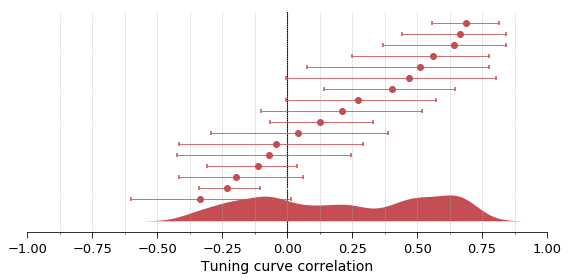

In [373]:
mean_xgb, low_xgb, high_xgb = plot_corr_scatter(all_corrs,'xgb','art.', lower = -2,
                                    color = sns.color_palette(n_colors=4)[3], save = False, percentile=5);

Population mean of -0.0262766993684 [-0.19412682  0.16742855]


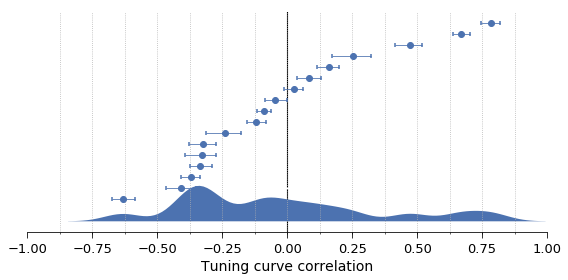

In [331]:
mean_vgg, low_vgg, high_vgg = plot_corr_scatter(all_corrs,'VGG','art.', lower = -2,
                                    color = sns.color_palette(n_colors=4)[0], save = False, percentile=5);

In [272]:
def get_all_null_dists(bootstrapped_fits, n_fits=1, which_neurons = []):
    """
    Correlates the tuning curves of one neuron with those of a different neuron built
    by a different method
    """
    nbins = 8
    n_neurons = 90

    methods = list(bootstrapped_fits[0].columns)
    
    all_corrs = pd.DataFrame(index = methods, columns = methods, dtype=object)
    # initialize the corr_coef lists
    for i,method1 in enumerate(methods):
        for method2 in methods[i:]:
            all_corrs.loc[method1,method2] = []
                
    hue = bootstrapped_fits[0].iloc[0,0]['plain_hue']
    
    for single_fit in tqdm(bootstrapped_fits[:n_fits]):
    
        for i,method in enumerate(methods):

            for method2 in methods[i:]:

                for nj, neuron_id in enumerate(which_neurons):
                    for neuron2_id in which_neurons[nj+1:]:

                        # Get the first curve...
                        if method=='art.':
                            x,y =  art_XGB.iloc[:,0][neuron_id]['hue'],                                                  art_XGB.iloc[:,0][neuron_id]['spike_counts']/                                                   art_XGB.iloc[:,0][neuron_id]['duration']
                            x,y = bootstrap2(x,y)

                            binned_TC1, _, _ = stats.binned_statistic(
                                           x,y,
                                              statistic='mean',bins = 8)
                        elif method == 'VGG':
                            slopes, errs,_ = get_slopes(neuron_id, diff_df_all_real)
                             # jitter around slopes
                            noised_slopes = slopes+ np.array([np.random.normal(scale=(slopes[i]-errs[i,0])/2)
                                                              for i in range(len(slopes))])
                            binned_TC1 = noised_slopes
                        else:
                            predicted_response = single_fit.loc[neuron_id,method]['plain_predicted_spike_counts']
                            binned_TC1, _,_  = stats.binned_statistic(
                                                        hue, predicted_response,
                                                        statistic='mean',range = (-np.pi,np.pi),
                                                              bins = 8)  
                        # Get the second curve...
                        if method2=='art.':
                            x,y =  art_XGB.iloc[:,0][neuron2_id]['hue'],                                                      art_XGB.iloc[:,0][neuron2_id]['spike_counts']/                                                       art_XGB.iloc[:,0][neuron2_id]['duration']
                            x,y = bootstrap2(x,y)

                            binned_TC2, _, _ = stats.binned_statistic(
                                           x,y,
                                              statistic='mean',bins = 8)
                        elif method2 == 'VGG':
                            slopes, errs,_ = get_slopes(neuron2_id, diff_df_all_real)
                             # jitter around slopes
                            noised_slopes = slopes+ np.array([np.random.normal(scale=(slopes[i]-errs[i,0])/2)
                                                              for i in range(len(slopes))])
                            binned_TC2 = noised_slopes
                        else:
                            predicted_response = single_fit.loc[neuron2_id,method2]['plain_predicted_spike_counts']
                            binned_TC2, _,_  = stats.binned_statistic(
                                                        hue, predicted_response,
                                                        statistic='mean',range = (-np.pi,np.pi),
                                                              bins = 8)  
                        # now correlate
                        this_corr_coef = np.corrcoef(binned_TC1, binned_TC2)[0,1]
                        # append to the proper list
                        all_corrs.loc[method,method2].append(this_corr_coef)            

    return all_corrs

def get_WFH_null_dists(art_XGB, n_iters=1):
    """
    Correlates the tuning curves of one neuron with those of a different neuron built
    by a different method
    """
    nbins = 8
    n_neurons = 80
    

    all_corrs_ = []
    for n in range(n_iters):
        for neuron_id in range(n_neurons):
            for neuron2_id in range(neuron_id+1,n_neurons):


                x,y =  art_XGB.iloc[:,0][neuron_id]['hue'],\
                                      art_XGB.iloc[:,0][neuron_id]['spike_counts']\
                                       /art_XGB.iloc[:,0][neuron_id]['duration']
                x,y = bootstrap2(x,y)

                binned_TC1, _, _ = stats.binned_statistic(
                               x,y,
                              statistic='mean',bins = 8)
    #           
                x,y =  art_XGB.iloc[:,0][neuron2_id]['hue'],\
                                      art_XGB.iloc[:,0][neuron2_id]['spike_counts']\
                                       /art_XGB.iloc[:,0][neuron2_id]['duration']
                x,y = bootstrap2(x,y)

                binned_TC2, _, _ = stats.binned_statistic(
                               x,y,
                                  statistic='mean',bins = 8)
    #                        
                # now correlate
                this_corr_coef = np.corrcoef(binned_TC1, binned_TC2)[0,1]
                # append to the proper list
                all_corrs_.append(this_corr_coef)            
            
    return all_corrs_

In [274]:
art_null = get_WFH_null_dists(art_XGB)

In [264]:
all_null_dists = get_all_null_dists(bootstrapped, 1, which_wfh_and_1Hz)




  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]




### Compare split-trial control with actual

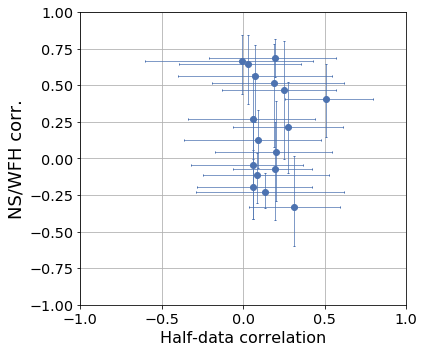

In [403]:
plt.figure(figsize = (6,5))
# plt.plot(mean_xgb_split, mean_xgb, 'o')
xgb_err_split = [mean_xgb_split-low_xgb_split, high_xgb_split-mean_xgb_split]
xgb_err = [mean_xgb-low_xgb, high_xgb-mean_xgb]

plt.errorbar(mean_xgb_split, mean_xgb, xerr=xgb_err_split, yerr = xgb_err,
             linestyle="None",  fmt = "o", elinewidth = .7, capsize =1)
plt.axis([-1,1,-1,1])
ax = plt.gca()
# simpleaxis(ax)
plt.grid()
plt.xlabel("Half-data correlation", fontsize = 16)
plt.ylabel("NS/WFH corr.",fontsize=18)
plt.tight_layout()

plt.savefig("final_figures/half-data-nsWFH-corr-xgb.pdf")

plt.show()

In [391]:
from scipy.stats import wilcoxon, ttest_rel, ttest_ind

In [393]:
np.mean(mean_xgb), np.mean(mean_xgb_split)

(0.21228969594601255, 0.15856728635115241)

In [395]:
wilcoxon(mean_xgb, mean_xgb_split, ), ttest_rel(mean_xgb, mean_xgb_split,)

(WilcoxonResult(statistic=67.0, pvalue=0.6529181068049057),
 Ttest_relResult(statistic=0.59297353890697913, pvalue=0.56148751771012473))

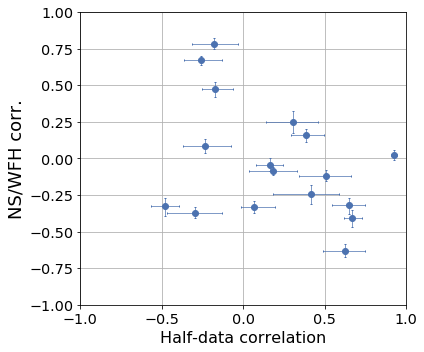

In [404]:
plt.figure(figsize = (6,5))
# plt.plot(mean_vgg_split, mean_vgg, 'o')
vgg_err_split = [mean_vgg_split-low_vgg_split, high_vgg_split-mean_vgg_split]
plt.errorbar(mean_vgg_split, mean_vgg, xerr=vgg_err_split, yerr = vgg_err,
             linestyle="None",  fmt = "o", elinewidth = .7, capsize =1)
plt.axis([-1,1,-1,1])
ax = plt.gca()
# simpleaxis(ax)
plt.grid()
plt.xlabel("Half-data correlation", fontsize = 16)
plt.ylabel("NS/WFH corr.",fontsize=18)
plt.tight_layout()
plt.savefig("final_figures/half-data-nsWFH-corr-vgg.pdf")
plt.show()

In [387]:
wilcoxon(mean_vgg_split, mean_vgg), ttest_rel(mean_vgg_split, mean_vgg)

(WilcoxonResult(statistic=47.0, pvalue=0.1625717591562893),
 Ttest_relResult(statistic=1.3516545501753807, pvalue=0.1952870429943937))

Or just above?

In [398]:
above0 = mean_vgg_split>0

wilcoxon(mean_vgg_split[above0], mean_vgg[above0],), ttest_rel(mean_vgg_split[above0], mean_vgg[above0],)

(WilcoxonResult(statistic=0.0, pvalue=0.0033456181158508813),
 Ttest_relResult(statistic=4.9692828349347877, pvalue=0.00056225891440831192))

In [364]:
def plot_corr_scatter_with_null(all_corrs, method1, method2,color = None,save=False, percentile =5,
                         ybins = 16.,simcolor = None,simcolor2 = None, null=True,
                            xbins = 16., simulated = None,simulated2 = None, f= 1,
                            lower=-8):
    all_corrs_for_these_two = all_corrs.loc[method1,method2]
    mean = np.nanmean(all_corrs_for_these_two,axis=0)
    try:
        low, high = CI_along_axis0_nan(all_corrs_for_these_two,percentile)
    except ValueError:
        method2,method1 = method1, method2
        all_corrs_for_these_two = all_corrs.loc[method1,method2]
        mean = np.nanmean(all_corrs_for_these_two,axis=0)
        low, high = CI_along_axis0_nan(all_corrs_for_these_two,percentile)
#         stds=np.nanstd(vals,axis=0)[:,i]*1.96
    if ('glm' in method1) or ('glm' in method2):
        good_GLM_neurons = ~np.isnan(mean)
        mean = mean[good_GLM_neurons]
        low = low[good_GLM_neurons]
        high = high[good_GLM_neurons]



    print("Population mean of {} {}".format(np.nanmean(all_corrs_for_these_two),
                                            bootstrap_nan(np.nanmean(all_corrs_for_these_two,axis=0))))
    if method1=='VGG':
        plt.figure(figsize=(9,5))
        directory = 'fig_4'
    else:
        plt.figure(figsize=(9,5))
        directory = 'fig_2'
    if color == None:
        color = sns.color_palette(n_colors=3)[0]

    y_jitter = 0.2*np.random.randn(len(mean))
#     y = y_jitter + return_number_in_bin(mean, bins = ybins)
    y = np.argsort(mean)
    plt.errorbar(mean[y],range(len(y)), fmt= 'o',
        xerr = [mean[y]-low[y], high[y]-mean[y]],
       elinewidth = .8, capsize=2,capthick=1.5, color = color)

#     special neurons
    
#     plt.errorbar(mean[[1,9]],[np.argwhere(y==1)[0,0],np.argwhere(y==9)[0,0]], fmt= 'o',
#         xerr = [mean[[1,9]]-low[[1,9]], high[[1,9]]-mean[[1,9]]],
#        elinewidth = .8, capsize=2,capthick=1.5, color='orange',zorder=3)

    ax = plt.gca()

    plt.xlim([-1,1])
    # the grid lines
    ax.set_xticks(np.arange(-1+2/xbins,1,2/xbins, ), minor=True)
    ax.set_xticks(np.arange(-1,1.1,4/xbins, ), minor=False)
    ax.axvline(ymin=lower, ymax = len(mean), c='k', zorder = 0, linewidth = 1.1)
    plt.grid(which = 'minor', linestyle=':')


    plt.xticks(fontsize= 13)
    plt.xlabel('NS/WFH Tuning curve correlation', fontsize=18)


    simpleaxis(ax)
    ax.spines['left'].set_visible(False)
    

    
    plt.yticks([])
    
    # the Null
    if null==True:
        sns.kdeplot(art_null,shade=True,ax=ax, color='w',bw=.07 ,zorder=0)

        line = ax.get_lines()[-1]
        x, y = line.get_data()

        ax.plot(x, lower+-f*y,lw=2.5,c='w' )
        ax.plot(x, lower+-f*y,lw=2, )
    
    # the simulated
    if not (simulated is None):        
        sns.kdeplot(simulated,shade=True,ax=ax, 
                    color='w',
                    bw=.07 ,zorder=0)

        line = ax.get_lines()[-1]
        x, y = line.get_data()

        if simcolor is None:
            cc = sns.color_palette(n_colors=4)[1]
        else:
            cc = simcolor
        ax.plot(x, lower+-f*y,'--',lw=3,c=cc,zorder=2)
        
        # the simulated
    if not (simulated2 is None):        
        sns.kdeplot(simulated2,shade=True,ax=ax, 
                    color='w',
                    bw=.07 ,zorder=0)

        line = ax.get_lines()[-1]
        x, y = line.get_data()

        if simcolor2 is None:
            cc = sns.color_palette(n_colors=4)[1]
        else:
            cc = simcolor2
        ax.plot(x, lower+-f*y,'--',lw=3,c=cc,zorder=2)
    

    # the lower density plot
    sns.kdeplot(mean,shade=True,ax=ax, color='w',bw=.07 ,zorder=0)
    

    line = ax.get_lines()[-1]
    x, y = line.get_data()
    
    ax.fill_between(x, y1=lower+-f*y, y2=lower, alpha=1, facecolor=color, zorder =2,)
            
    plt.ylim(lower
             ,len(which_wfh_and_1Hz))
    
    plt.tight_layout()
    if save:
        plt.savefig("final_figures/corr_scatter-{}-{}.pdf".format(method1,method2),format='pdf')
    plt.show()
    return ax

Population mean of 0.212289695946 [ 0.0450317   0.37658563]


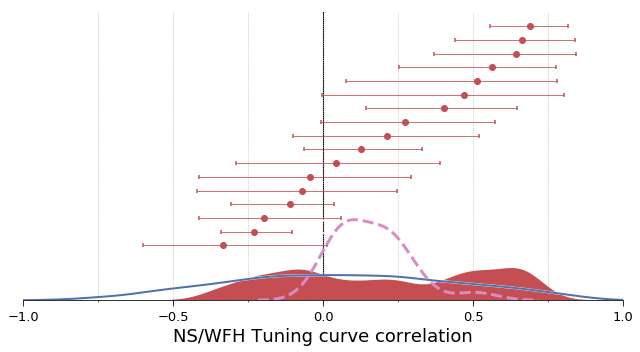

In [365]:
plot_corr_scatter_with_null(all_corrs,'xgb','art.',
                  color = sns.color_palette(n_colors=4)[3],
                  simcolor = sns.color_palette(n_colors=7)[-1],
                    simulated= mean_xgb,lower=-4,f=-2,
                  save = True, percentile=5, xbins = 8.)

Population mean of -0.0262766993684 [-0.19177657  0.16858303]


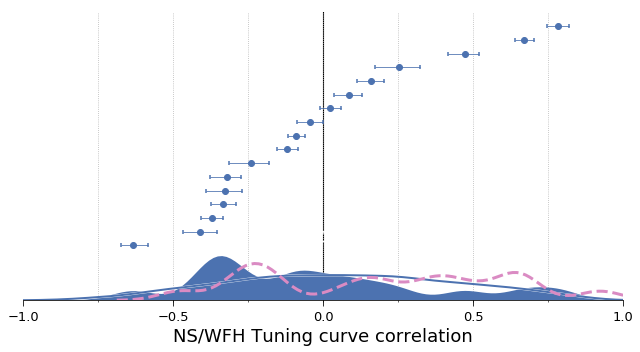

In [366]:
plot_corr_scatter_with_null(all_corrs,'VGG','art.',
                  color = sns.color_palette(n_colors=4)[0],
                  simcolor = sns.color_palette(n_colors=7)[-1],
                    simulated= mean_vgg_split,lower=-4,f=-2,
                  save = True, percentile=5, xbins = 8.)

In [248]:
plot_corr_scatter_with_null(all_corrs,'VGG','art.',
                  color = sns.color_palette(n_colors=4)[0],simulated= sim_corrs,
                  save = False, percentile=5, xbins = 8.)

NameError: name 'sim_corrs' is not defined

In [68]:
def get_pr2s(method, bootstrapped_fits, which_neurons, SEM = False, plt_hist = False):
    """For all the neurons, return the means and the standard deviation of the pr2s"""
    means = []
    stds = []
    for neuron_id in which_neurons:
        this_pr2 = []
        for single_fit in bootstrapped:
            this_pr2 += single_fit[method][neuron_id]['pseudo_R2']
        # some values are essentially NaN but appear as huge. 
        this_pr2 = np.array(this_pr2)
        this_pr2 = this_pr2[this_pr2>-10]
        this_pr2 = this_pr2[this_pr2<1]
        if plt_hist:
            plt.hist(this_pr2)
            plt.show()

        means.append(np.nanmean(this_pr2))
        n = np.sqrt(len(this_pr2)) if SEM else 1
        stds.append(np.nanstd(this_pr2)/n)
    return means, stds

In [69]:
pr2_means_glm, pr2_stds_glm = get_pr2s('glm_lowreg',bootstrapped, which_neurons,SEM = False)
pr2_means_xgb, pr2_stds_xgb = get_pr2s('xgb',bootstrapped, which_neurons,plt_hist=False, SEM = False)

In [70]:
import mpl_toolkits.axes_grid.inset_locator as il


/opt/anaconda/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/opt/anaconda/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


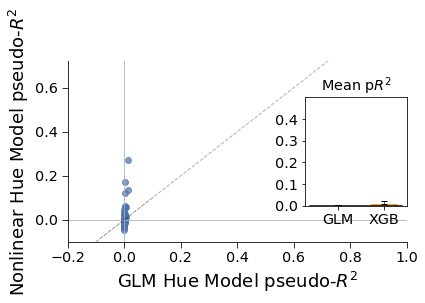

In [71]:
colors=['#EF3E34', '#F5A21E', '#134B64',  '#02A68E', '#FF07CD']*2
plt.scatter(pr2_means_glm, pr2_means_xgb, alpha = 0.7)
ax = plt.gca()
simpleaxis(ax)

plt.xlabel('GLM Hue Model pseudo-$R^2$',fontsize=18)
plt.ylabel('Nonlinear Hue Model pseudo-$R^2$',fontsize=18)
plt.axis([-0.2,1,-.1,.72])

ax.set_yticks([0], minor=True)
ax.set_xticks([0], minor=True)
plt.grid(which='minor')

lim = -0.1
alpha_lines = 0.3
plt.plot([-lim, lim], [-lim, lim], 'k:', lw=1, alpha=alpha_lines)
plt.plot([-1, 1], [-1, 1], 'k--', lw=1, alpha=alpha_lines)

# insert bar chart that is the average
means = [np.mean(pr2_means_glm), np.mean(pr2_means_xgb)]
mean_err = [np.std(pr2_means_glm)/np.sqrt(80), np.std(pr2_means_xgb)/np.sqrt(80)]

freq=0.1
ylim =[0,.5]

inset_axes = il.inset_axes(ax, 
                width="30%", # width = 34% of parent_bbox
                height="60%", 
                loc=7, borderpad = 0,
                axes_kwargs = {'title':'Mean p$R^2$',
                              'yticks':np.arange(ylim[0],ylim[1],freq),
                               'ylim':ylim })

labels =['GLM','XGB']
plt.bar(np.arange(np.size(means)), means, 0.6, align='center',
        ecolor='k', alpha=.9, color=colors, ec='w',yerr = mean_err,
        tick_label=labels, error_kw= {'elinewidth' : .6, 'capsize' : 3})
plt.plot([-.6,len(labels)-.6],[0,0],color='black',)
plt.tight_layout()
# plt.savefig("final_figures/pr2_scatter_glm_xgb.pdf")

/opt/anaconda/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


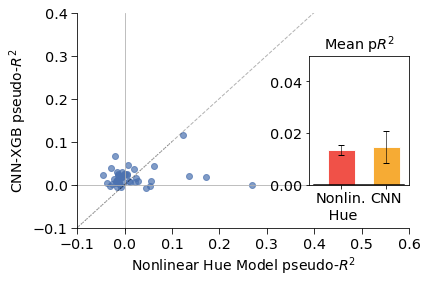

In [78]:
pr2_vgg = np.array(pickle.load(open( "vgg_pr2s_all.p", "rb" ) ))
colors=['#EF3E34', '#F5A21E', '#134B64',  '#02A68E', '#FF07CD']*2
plt.scatter(pr2_means_xgb, np.mean(pr2_vgg,axis=1)[which_neurons], alpha = 0.7)
ax = plt.gca()
simpleaxis(ax)

plt.ylabel('CNN-XGB pseudo-$R^2$',fontsize=14)
plt.xlabel('Nonlinear Hue Model pseudo-$R^2$',fontsize=14)
plt.axis([-0.1,.6,-.1,.4])

ax.set_yticks([0], minor=True)
ax.set_xticks([0], minor=True)
plt.grid(which='minor')

lim = -0.1
alpha_lines = 0.3
plt.plot([-lim, lim], [-lim, lim], 'k:', lw=1, alpha=alpha_lines)
plt.plot([-1, 1], [-1, 1], 'k--', lw=1, alpha=alpha_lines)

# insert bar chart that is the average
means = [np.mean(np.mean(pr2_vgg,axis=1)), np.mean(pr2_means_xgb)]
mean_err = [np.std(np.mean(pr2_vgg,axis=1))/np.sqrt(80), np.std(pr2_means_xgb)/np.sqrt(80)]

freq=0.02
ylim =[0,.05]

inset_axes = il.inset_axes(ax, 
                width="30%", # width = 34% of parent_bbox
                height="60%", 
                loc=7, borderpad = 0,
                axes_kwargs = {'title':'Mean p$R^2$',
                              'yticks':np.arange(ylim[0],ylim[1],freq),
                               'ylim':ylim })

labels =['Nonlin.\n Hue','CNN']
plt.bar(np.arange(np.size(means)), means, 0.6, align='center',
        ecolor='k', alpha=.9, color=colors, ec='w',yerr = mean_err,
        tick_label=labels, error_kw= {'elinewidth' : .6, 'capsize' : 3})
plt.plot([-.6,len(labels)-.6],[0,0],color='black',)
plt.tight_layout()
# plt.savefig("final_figures/pr2_scatter_vgg_xgb.pdf")

### Make some final scatter plots

In [321]:
VGG_pr2s = pickle.load(open( "vgg_pr2s_all.p", "rb" ) )[which_wfh_and_1Hz]
VGG_pr2 = np.mean(VGG_pr2s, axis=1)
VGG_pr2_std = np.std(VGG_pr2s, axis=1)

p of 0.32666661191


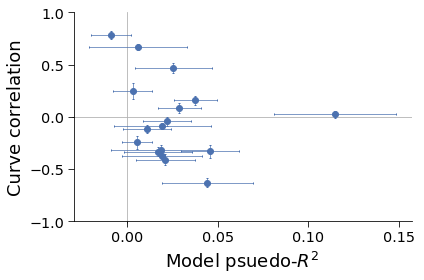

In [341]:
vgg_err = [mean_vgg-low_vgg, high_vgg-mean_vgg]
plt.errorbar(VGG_pr2, mean_vgg, xerr=VGG_pr2_std, yerr = vgg_err,
             linestyle="None",  fmt = "o", elinewidth = .7, capsize =1)
plt.ylim([-1,1])
ax = plt.gca()
ax.set_yticks([0], minor=True)
ax.set_xticks([0], minor=True)

plt.grid(which = 'minor')

plt.xlabel('Model psuedo-$R^2$', fontsize = 18)
plt.ylabel('Curve correlation',  fontsize = 18)
# plt.ylim([-1,1])
slope, intercept, r_value, p_value, std_err = stats.linregress(VGG_pr2,mean_vgg)
print("p of {}".format(p_value))
simpleaxis(ax)
plt.tight_layout()
plt.savefig('final_figures/VGG_pr2_vs_corr.pdf', format='pdf')
plt.show()